<a href="https://colab.research.google.com/github/itsfaryar/AiCup2021/blob/main/Arabic_broken_plurals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries & Constants**

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Conv2D, MaxPool2D, Embedding, Reshape, Flatten, LSTM, GRU, SimpleRNN, Concatenate, concatenate, RepeatVector, TimeDistributed, Bidirectional
# from keras.layers.merge import concatenate
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences #from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import os
import string
from google.colab import drive
import json

from transformers import AutoTokenizer,BertTokenizer,TFBertModel

import copy

# **Declaring And Initializing Global Variables**

## **Paths**

In [3]:
drive.mount('/content/drive')
dataPath="/content/drive/MyDrive/AI Projects/Arabic Broken Plural/data"
# dataPath = '/content/drive/MyDrive/Deep Learning/Datasets/Arabic Broken Plural/data'

data_analysis_path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Datasets analysis/'

Mounted at /content/drive


## **Global Variables Used For Encoding Data**

In [4]:
# generate character encoding
oov_token = 'not available char'
char_index = {oov_token: 0}
char_index_key_list = list(char_index.keys())
char_index_val_list = list(char_index.values())

# **Helper Functions**

In [5]:
def oneHot2D(arr):
    tmp = np.zeros_like(arr)
    tmp[np.arange(len(arr)), arr.argmax(1)] = 1
    return tmp

def oneHot3D(arr):
    tmp = np.array([oneHot2D(x) for x in arr])
    return tmp

In [6]:
def updateCharIndex(data):
  global char_index , char_index_key_list , char_index_val_list
  # encode input with encoding character set
  for i in range(len(data[0])):
      chars = data[0][i] + data[1][i] + data[3][i] + data[4][i]
      for c in chars:
          if c not in char_index:
              char_index[c] = len(char_index)
  char_index_key_list = list(char_index.keys())
  char_index_val_list = list(char_index.values())

def getCharFromIdx(idx):
  position = char_index_val_list.index(idx)
  return char_index_key_list[position]

def getWordFromOnehot(onehot):
  encoded=np.argmax(onehot, axis=1)
  word=[]
  for x in encoded:
    if x==0:break
    word.append(getCharFromIdx(x))
  return ''.join(word)

In [7]:
# find duplicates and create dictionaries
def getDuplicateIndexes(data):
  dupindex={}
  for i in range(len(data[0])):
    lemma = data[0][i]
    if dupindex.get(lemma)==None :
      dupindex[lemma]=[]
      dupindex[lemma].append(i)
    elif len(data)<9:
      dupindex[lemma].append(i)
    else:
      f=False
      for k in range(len(dupindex[lemma])):
        if data[8][i] > data[8][dupindex[lemma][k]]:
          dupindex[lemma].insert(0,i)
          f=True
      if not f : dupindex[lemma].append(i)


  return dupindex

def reportErrorAnalysis_duplicates(dataframe,dicDup,path):
  df=dataframe.loc[[]]
  
  indexes=[]
  for key, value in dicDup.items():
    if len(value)>1 :
      for x in value:
        n=len(df)
        indexes.append(x)
        df.loc[n]=dataframe.loc[x]
  df.insert(0, "index", indexes, True)
  df.to_csv(path)
  return df

#Generate lemma-inflection reference
def updateDic_lemmaInflection(data,inflection_index,dupIndex,dic_lemmaInflection):
  for key, value in dupIndex.items():
    if dic_lemmaInflection.get(key)==None:
      dic_lemmaInflection[key]=[]
    for x in value : 
      if not data[inflection_index][x] in dic_lemmaInflection[key]: dic_lemmaInflection[key].append(data[inflection_index][x])
  return dic_lemmaInflection


def report_similarLemmas(lemma, inflection, dic, path, name):
  '''
  Get a csv report on similar lemmas comparing to a dictionary
  inputs = list of lemmas, list inflections,
    reference dictionary, saving path for the report,
    name of the report
  output = report in csv format
  '''
  report={'index':[], 'lemma':[], 'new inflection':[], 'old inflection':[],'is_similar':[]}

  for i in range(len(lemma)):
    if dic.get(lemma[i])==None:
      continue
    else:
      report['index'].append(i)
      report['lemma'].append(lemma[i])
      report['new inflection'].append(inflection[i])
      report['old inflection'].append(dic.get(lemma[i])[0])
      report['is_similar'].append(dic.get(lemma[i])[0]==inflection[i])
  df = pd.DataFrame(report) 
  df.to_csv(path+"/"+name+".csv")
  return df


In [8]:
#Drop unnecessary duplicates
def getUniqueData(data,dupIndex):
  out=[]
  #init nested lists
  for x in data: out.append([])
  #fill out with most frequent lemma-inflection pairs
  for key, value in dupIndex.items():
    for k in range(len(data)):
      out[k].append(data[k][value[0]])
  return out

#Fix defferent inflection comparing to a dictionary of lemma-inflection pairs
def fixInflections(data,inflection_index,dic):
  out = copy.deepcopy(data)
  c=0
  for i in range(len(data[0])):
    if dic.get(data[0][i])==None:
      continue
    else:
      inf = dic.get(data[0][i])[0]
      if not data[inflection_index][i] == inf:
        out[inflection_index][i]=inf
        c+=1
  return out,c

In [9]:
def binaryConversion(arr, threshold=0.5):
  tmp = np.zeros_like(arr)
  tmp[arr > threshold] = 1
  return tmp

def reportResult(model, history, X_test, y_test):

    # best models based on acc or loss in tarin set or test set
    testHistory = list(
        map(lambda x, y: [x, y], history['val_accuracy'], history['val_loss']))
    print(
        f"best model based on min test set loss:  acc= {min(testHistory, key = lambda k: k[1])[0]}  loss= {min(testHistory, key = lambda k: k[1])[1]}")
    print(
        f"best model based on max test set accuracy:  acc= {max(testHistory, key = lambda k: k[0])[0]}  loss= {max(testHistory, key = lambda k: k[0])[1]}")

    print("\nevaluate dataset with best model based on maximum test set accuracy")
    print("evaluate test set = ", model.evaluate(X_test, y_test, verbose=0))

    y_test_pred = model.predict(X_test)
    y_test_pred = binaryConversion(y_test_pred)

    # confusion matrix and precision, recall and f1 report
    print('-'*30, 'metrics for test set', '-'*30)
    print("confusion matrix: \n", metrics.confusion_matrix(y_test, y_test_pred))
    print(metrics.classification_report(y_test,
          y_test_pred, digits=3, target_names=['Broken', 'Sound']))
    
def argmaxKeepDimensions(arr):
  tmp = np.zeros_like(arr)
  tmp[np.arange(len(arr)), arr.argmax(1)] = 1
  return tmp

def checkAccuracy(pred, true):
  size = pred.shape[0]
  numOfTrue = 0
  for (x, y) in zip(pred, true):
    if np.array_equal(x, y):
      numOfTrue += 1
  
  return size-numOfTrue, numOfTrue/size

def checkAccuracy_anyAcceptableInflectionInDataset(lemma, pred, dic_refrence):
  size = pred.shape[0]
  numOfTrue = 0
  for i in range (len(pred)):
    w=getWordFromOnehot(pred[i])
    if w in dic_refrence[lemma[i]]:
      numOfTrue += 1
  
  return size-numOfTrue, numOfTrue/size

def reportErrorAnalysis(lemma, bs, pred_OH, inflection_OH, path):
  size = pred_OH.shape[0]
  report={'index':[], 'lemma':[], 'b/s':[], 'inflection':[], 'predict':[]}
  i=0
  for (x, y) in zip(pred_OH, inflection_OH):
    if not np.array_equal(x, y):
      report['index'].append(i)
      report['lemma'].append(lemma[i])
      if bs==None:
        report['b/s'].append("NAN")
      else:
        report['b/s'].append(bs[i])
      report['inflection'].append(getWordFromOnehot(inflection_OH[i]))
      report['predict'].append(getWordFromOnehot(pred_OH[i]))
    i+=1
  
  df = pd.DataFrame(report) 
  df.to_csv(path)
  return df

def reportErrorAnalysis_inflectionWithBS(lemma, bs,bs_pred, pred_OH, inflection_OH, path):
  size = pred_OH.shape[0]
  report={'index':[], 'lemma':[], 'b/s':[], 'b/s predict':[], 'inflection':[], 'predict':[]}
  bs_pred = binaryConversion(bs_pred)
  i=0
  for (x, y) in zip(pred_OH, inflection_OH):
    if not np.array_equal(x, y):
      report['index'].append(i)
      report['lemma'].append(lemma[i])
      report['b/s'].append(bs[i])
      report['b/s predict'].append(bs_pred[i])
      report['inflection'].append(getWordFromOnehot(inflection_OH[i]))
      report['predict'].append(getWordFromOnehot(pred_OH[i]))
    i+=1
  
  df = pd.DataFrame(report) 
  df.to_csv(path)
  return df

def reportErrorAnalysis_classification(lemma, inflection_OH, bs, bs_pred, path):
  size = bs.shape[0]
  report={'index':[], 'lemma':[], 'inflection':[],'b/s':[], 'b/s predict':[] }
  bs_pred = binaryConversion(bs_pred, 0.5)
  i=0
  for (x, y) in zip(bs, bs_pred):
    if not x==y:
      report['index'].append(i)
      report['lemma'].append(lemma[i])
      report['b/s'].append(x)
      report['inflection'].append(getWordFromOnehot(inflection_OH[i]))
      report['b/s predict'].append(y)
    i+=1
  
  df = pd.DataFrame(report) 
  df.to_csv(path)
  return df

In [10]:
def reportPercentageOfBrokenSoundErrors(dataset_errorAnalysis):
  total_errors_num = dataset_errorAnalysis.shape[0]
  train_sound_error = np.sum(dataset_errorAnalysis['b/s'])
  train_broken_error = total_errors_num - train_sound_error
  return train_broken_error/total_errors_num * 100, train_sound_error/total_errors_num * 100

def reportPercentageOfUnseenErrors(errorIndices, unseenIndices):
  isInUnseen = np.array([index in unseenIndices for index in errorIndices])
  return np.count_nonzero(isInUnseen==True) / len(errorIndices) * 100, np.count_nonzero(isInUnseen==True) / len(unseenIndices) * 100

## **Encoding Schemes**

In [11]:
encoding_schemes = pd.read_excel(dataPath+"/Encoding Schemes.xlsx")

In [12]:
arabic_bw = encoding_schemes[['Arabic', 'BW']]
arabic_bw.shape[0]

51

In [13]:
bw_to_arabic, arabic_to_bw = {}, {}
for i in range(arabic_bw.shape[0]):
  bw_to_arabic[arabic_bw['BW'][i]] = arabic_bw['Arabic'][i]
  arabic_to_bw[arabic_bw['Arabic'][i]] = arabic_bw['BW'][i]

In [14]:
print(bw_to_arabic)

{"'": 'ء', '|': 'آ', '>': 'أ', '&': 'ؤ', '<': 'إ', '}': 'ئ', 'A': 'ا', 'b': 'ب', 'p': 'ة', 't': 'ت', 'v': 'ث', 'j': 'ج', 'H': 'ح', 'x': 'خ', 'd': 'د', '*': 'ذ', 'r': 'ر', 'z': 'ز', 's': 'س', '$': 'ش', 'S': 'ص', 'D': 'ض', 'T': 'ط', 'Z': 'ظ', 'E': 'ع', 'g': 'غ', '_': 'ـ', 'f': 'ف', 'q': 'ق', 'k': 'ك', 'l': 'ل', 'm': 'م', 'n': 'ن', 'h': 'ه', 'w': 'و', 'Y': 'ى', 'y': 'ي', 'F': 'ً', 'N': 'ٌ', 'K': 'ٍ', 'a': 'َ', 'u': 'ُ', 'i': 'ِ', '~': 'ّ', 'o': 'ْ', '`': 'ٰ', '{': 'ٱ', 'P': 'پ', 'J': 'چ', 'V': 'ڤ', 'G': 'گ'}


In [15]:
def getArabicForm(bwForm):
  global bw_to_arabic
  arabicForm = []
  for x in bwForm:
    arabicForm.append("".join([bw_to_arabic[char] for char in x]))
  return arabicForm

def getBWForm(arabicForm):
  global arabic_to_bw
  bwForm = []
  for x in arabicForm:
    bwForm.append("".join([arabic_to_bw[char] for char in x]))
  return bwForm

# **Preprocessing**

## **Hugging face Arabic Bert Config**

In [16]:
#bert_tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
bert_tokenizer = BertTokenizer.from_pretrained("asafaya/bert-base-arabic")

In [17]:
encoding = bert_tokenizer.encode_plus(
      'علم',
      max_length=18,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
      return_token_type_ids=True,
      padding = 'max_length',  # Pad to longest in batch.
      truncation=True,
      return_attention_mask=True,
      return_tensors='tf'  # Return PyTorch tensors
    )
#print(len(encoding['token_type_ids'][0]))

In [18]:
bert_test=bert_tokenizer("عِلمة")

In [19]:
print(bert_test)

{'input_ids': [2, 2816, 1012, 3], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}


## **Get dataset files and Organizing**

In [20]:
train_csv = pd.read_csv(dataPath+"/train_pairs_all.csv")
dev_csv = pd.read_csv(dataPath+"/dev_pairs_all.csv")
test_csv = pd.read_csv(dataPath+"/test_pairs_all.csv")

train_csv.head()

,lemma,inflection,NUM,GEN,RAT,lex_freq,B/S,SING_PATT,PL_PATT,ROOT,FREQ
0,Eamal,>aEomAl,PL,m,i,49,B,1a2a3,>a1o2A3,E.m.l,49
1,hadaf,>ahodAf,PL,m,i,42,B,1a2a3,>a1o2A3,h.d.f,42
2,EuDow,>aEoDA',PL,m,r,46,B,1u2ow,>a1o2A',E.D.#,39
3,jihAz,>ajohizap,PL,m,i,41,B,1i2A3,>a1o2i3ap,j.h.z,35
4,Hukom,>aHokAm,PL,m,i,35,B,1u2o3,>a1o2A3,H.k.m,35


In [21]:
train_csv_filtered = train_csv[train_csv['ROOT'] != 'NTWS']
dev_csv_filtered = dev_csv[dev_csv['ROOT'] != 'NTWS']
test_csv_filtered = test_csv[test_csv['ROOT'] != 'NTWS']

In [22]:
print(train_csv.shape[0] - train_csv_filtered.shape[0])
print(dev_csv.shape[0] - dev_csv_filtered.shape[0])
print(test_csv.shape[0] - test_csv_filtered.shape[0])

114
38
27


In [23]:
# Label encoder for encoding gender and rational features
# 'B' class: 0      'S' class: 1
categorical_attr = ['GEN', 'RAT', 'B/S']

le = LabelEncoder()
#train_csv_filtered[categorical_attr] = train_csv_filtered[categorical_attr].apply(le.fit_transform, axis=0)
train_csv[categorical_attr] = train_csv[categorical_attr].apply(le.fit_transform, axis=0)

le = LabelEncoder()
#dev_csv_filtered[categorical_attr] = dev_csv_filtered[categorical_attr].apply(le.fit_transform, axis=0)
dev_csv[categorical_attr] = dev_csv[categorical_attr].apply(le.fit_transform, axis=0)

le = LabelEncoder()
#test_csv_filtered[categorical_attr] = test_csv_filtered[categorical_attr].apply(le.fit_transform, axis=0)
test_csv[categorical_attr] = test_csv[categorical_attr].apply(le.fit_transform, axis=0)

#test_csv_filtered.head()
test_csv.head()

,lemma,inflection,NUM,GEN,RAT,lex_freq,B/S,SING_PATT,PL_PATT,ROOT,FREQ
0,Eamal,>aEomAl,PL,1,0,23,0,1a2a3,>a1o2A3,E.m.l,23
1,hadaf,>ahodAf,PL,1,0,16,0,1a2a3,>a1o2A3,h.d.f,16
2,EalAqap,EalAqAt,PL,0,0,15,1,1a2A3ap,1a2A3At,E.l.q,15
3,mu&as~asap,mu&as~asAt,PL,0,0,14,1,mu&a2~a3ap,mu&a2~a3At,#.s.s,14
4,EuDow,>aEoDA',PL,1,1,15,0,1u2ow,>a1o2A',E.D.#,13


In [24]:
def getListOfData(dataFrame):
  '''
  Output type->List : 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational | 8:freq | 9:nmberOfRoot | 10:Arabic Form |
  '''
  data = [] # 0:lemma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
  data.append(dataFrame['lemma'].tolist())
  data.append(dataFrame['SING_PATT'].tolist())

  root = dataFrame['ROOT'].tolist()
  # delete dot sign(.) in root feature
  for i in range(len(root)): 
    root[i] = root[i].replace(".","")
    root[i] = root[i].replace("#","")
  data.append(root)

  data.append(dataFrame['inflection'].tolist())
  data.append(dataFrame['PL_PATT'].tolist())
  data.append(dataFrame['B/S'].tolist())
  data.append(dataFrame['GEN'].tolist())
  data.append(dataFrame['RAT'].tolist())
  data.append(dataFrame['FREQ'].tolist())

  numOfRoot = [len(x) for x in root]
  data.append(numOfRoot)

  data.append(getArabicForm(dataFrame['lemma'].tolist()))

  return data

trainData = getListOfData(train_csv)
devData = getListOfData(dev_csv)
testData = getListOfData(test_csv)
is_dataOrginal=True

## **Sentiment Analysis Model**

In [25]:
pip install camel-tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.2/418.2 KB 46.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for camel-kenlm: filename=camel_kenlm-2021.12.27-cp38-cp38-linux_x86_64.whl size=2972423 sha256=0d5bdab75581569bfd5dd8818a66d8f2b8b8302633862b925c4f7160dbb3cd54
  Stored in directory: /root/.cache/pip/wheels/2c/7b/f0/837fcdb48cd99564b1163d90392f350cb933fce3bf122eadcd
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=34a2d0ced1f82f9c71685367b83515e57fb7c803bf4d55e12aee0223f721e89b
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6

In [26]:
from camel_tools.sentiment import SentimentAnalyzer

sa = SentimentAnalyzer("CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment")

In [27]:
print(trainData[0][1])
sentences = [trainData[10][0], trainData[0][1]]

sa.predict(sentences)

hadaf


['neutral', 'neutral']

## **Work On Duplicates**

In [28]:
if is_dataOrginal:
  #Save similar lemmas indexes in dictionary (key->lemma | value->list of indexes)
  trainDupIndex=getDuplicateIndexes(trainData)
  devDupIndex=getDuplicateIndexes(devData)
  testDupIndex=getDuplicateIndexes(testData)
  print("duplicate indexes has been updated")
  print(trainDupIndex)

if is_dataOrginal:
  #Save Duplicate report on data in csv
  trainDuplicateCsv=reportErrorAnalysis_duplicates(train_csv,trainDupIndex,data_analysis_path+"/duplicateAnalysis_train.csv")
  devDuplicateCsv=reportErrorAnalysis_duplicates(dev_csv,devDupIndex,data_analysis_path+"/duplicateAnalysis_dev.csv")
  testDuplicateCsv=reportErrorAnalysis_duplicates(test_csv,testDupIndex,data_analysis_path+"/duplicateAnalysis_test.csv")
  print("Report Error Analysis on duplicates has been saved in /content/drive/MyDrive/AI Projects/Arabic Broken Plural/Datasets analysis path")

dic_lemmaInflection = {}
if is_dataOrginal:
  dic_lemmaInflection = updateDic_lemmaInflection(trainData,3,trainDupIndex,dic_lemmaInflection)
  print(len(dic_lemmaInflection))
  dic_lemmaInflection = updateDic_lemmaInflection(testData,3,testDupIndex,dic_lemmaInflection)
  print(len(dic_lemmaInflection))
  dic_lemmaInflection = updateDic_lemmaInflection(devData,3,devDupIndex,dic_lemmaInflection)
  print(len(dic_lemmaInflection))

duplicate indexes has been updated
{'Eamal': [0], 'hadaf': [1], 'EuDow': [2, 815, 1619], 'jihAz': [3, 689], 'Hukom': [4], 'EunoSur': [5], 'Haq~': [6], 'maSolaHap': [7], 'Eamaliy~ap': [8], 'farod': [9], 'siEor': [10], '<imokAn': [11], "<ijorA'": [12], 'mawoqif': [13], 'jahod': [14], 'quw~ap': [15, 292, 933, 1650, 1827, 1835, 1845], 'EalAqap': [16], 'sabab': [17], 'Sawot': [18], 'qarAr': [19], 'silAH': [20, 394], '>avar': [21], 'Tifol': [22], 'Hadav': [23], 'balad': [24, 102], 'natiyjap': [25], 'Zarof': [26], '{it~iSAl': [27], 'waDoE': [28], 'mu&as~asap': [29], 'TAlib': [30, 674, 1119, 1345, 2715, 2716], 'fikor': [31], 'niZAm': [32, 888, 1138], 'taSoriyH': [33, 1208], '>aroD': [34, 1204], 'tahodiyd': [35], 'dawolap': [36, 453], 'walad': [37], 'mAl': [38], 'baronAmaj': [39], 'yawom': [40], 'ma$oruwE': [41, 1375], 'Had~': [42], 'Taraf': [43], 'mAd~ap': [44], 'SAHib': [45, 2573], '{inotixAb': [46], '$aEob': [47], 'jaw~': [48, 2405], 'maTolab': [49], 'TA}irap': [50], 'HuDuwr': [51], 'minoTaq

In [29]:
#Drop unnecessary duplicates
trainDataUnique=getUniqueData(trainData,trainDupIndex)
devDataUnique=getUniqueData(devData,devDupIndex)
testDataUnique=getUniqueData(testData,testDupIndex)
print("Number Of Lemmas before Dropping duplicates in Train Set: ", len(trainData[0]))
print("Number Of Lemmas before Dropping duplicates in Test Set: ",len(testData[0]))
print("Number Of Lemmas before Dropping duplicates in Dev Set: ",len(devData[0]))
print("=============================================================")
print("Number Of Lemmas After Dropping duplicates in Train Set: ", len(trainDataUnique[0]))
print("Number Of Lemmas After Dropping duplicates in Test Set: ",len(testDataUnique[0]))
print("Number Of Lemmas After Dropping duplicates in Dev Set: ",len(devDataUnique[0]))

Number Of Lemmas before Dropping duplicates in Train Set:  2862
Number Of Lemmas before Dropping duplicates in Test Set:  1103
Number Of Lemmas before Dropping duplicates in Dev Set:  1151
Number Of Lemmas After Dropping duplicates in Train Set:  2475
Number Of Lemmas After Dropping duplicates in Test Set:  1028
Number Of Lemmas After Dropping duplicates in Dev Set:  1060


In [30]:
#Fix defferent inflection comparing to a dictionary of lemma-inflection pairs

trainFixedData , c = fixInflections(trainDataUnique,3,dic_lemmaInflection)
print("Number of changed inflections in train dataset:",c)
devFixedData , c = fixInflections(devDataUnique,3,dic_lemmaInflection)
print("Number of changed inflections in dev dataset:",c)
testFixedData , c = fixInflections(testDataUnique,3,dic_lemmaInflection)
print("Number of changed inflections in test dataset:",c)

Number of changed inflections in train dataset: 0
Number of changed inflections in dev dataset: 34
Number of changed inflections in test dataset: 26


In [31]:
if is_dataOrginal:
  trainData=trainDataUnique
  devData=devDataUnique
  testData=testDataUnique
  is_dataOrginal=False
else:
  print("Warning!!! duplicate rows has already been dropped from data.(skipped this step)")

## **Encoding Datasets (Character-based)**

In [32]:
updateCharIndex(trainData)
print(len(char_index))
print(char_index)

50
{'not available char': 0, 'E': 1, 'a': 2, 'm': 3, 'l': 4, '1': 5, '2': 6, '3': 7, '>': 8, 'o': 9, 'A': 10, 'h': 11, 'd': 12, 'f': 13, 'u': 14, 'D': 15, 'w': 16, "'": 17, 'j': 18, 'i': 19, 'z': 20, 'p': 21, 'H': 22, 'k': 23, 'n': 24, 'S': 25, 'r': 26, '4': 27, 'q': 28, '~': 29, 'y': 30, 't': 31, 's': 32, '<': 33, 'b': 34, 'v': 35, '|': 36, 'T': 37, '}': 38, 'Z': 39, '{': 40, '&': 41, '$': 42, 'x': 43, 'N': 44, 'W': 45, '*': 46, 'g': 47, 'Y': 48, 'F': 49}


In [33]:
# encode words with character encoder
def encodeWord(word, dic=char_index, oov=oov_token):
    return [dic[c] if c in dic else dic[oov] for c in list(word)]

# encode data and get maximum length of features
def getEncodedData(data):
  '''
  Output type->List : 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational | 8:number of root
  '''

  data_encoded = data.copy()
  data_encoded[0] = [encodeWord(each) for each in data[0]]
  data_encoded[1] = [encodeWord(each) for each in data[1]]
  data_encoded[2] = [encodeWord(each) for each in data[2]]
  data_encoded[3] = [encodeWord(each) for each in data[3]]
  data_encoded[4] = [encodeWord(each) for each in data[4]]

  lemma_max_len = max([len(each) for each in data_encoded[0]])
  root_max_len = max([len(each) for each in data_encoded[2]])
  inflection_max_len = max([len(each) for each in data_encoded[3]])

  return data_encoded, lemma_max_len, root_max_len, inflection_max_len


trainData_encoded, lemma_max_len, root_max_len, inflection_max_len = getEncodedData(trainData)
devData_encoded, _, _, _  = getEncodedData(devData)
testData_encoded, _, _, _ = getEncodedData(testData)

print('lemma shape train: ', len(trainData_encoded[0]))
print('lemma shape dev: ', len(devData_encoded[0]))
print('lemma shape test: ', len(testData_encoded[0]))
print('max length in lemma elements: ', lemma_max_len)
print('max length in root elements: ', root_max_len)
print('max length in inflection elements: ', inflection_max_len)

lemma shape train:  2475
lemma shape dev:  1060
lemma shape test:  1028
max length in lemma elements:  17
max length in root elements:  4
max length in inflection elements:  18


In [34]:
# ADD padding to sample
# 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
def getPaddedData(encodedData, lemma_max_len, root_max_len, inflection_max_len):
  data_pad = []
  data_pad.append(np.array(pad_sequences(encodedData[0], maxlen=lemma_max_len, padding='post'))) 
  data_pad.append(np.array(pad_sequences(encodedData[1], maxlen=lemma_max_len, padding='post')))
  data_pad.append(np.array(pad_sequences(encodedData[2], maxlen=root_max_len, padding='post')))
  data_pad.append(np.array(pad_sequences(encodedData[3], maxlen=inflection_max_len, padding='post')))
  data_pad.append(np.array(pad_sequences(encodedData[4], maxlen=inflection_max_len, padding='post')))
  data_pad.append(np.array(encodedData[5]))
  data_pad.append(np.array(encodedData[6]))
  data_pad.append(np.array(encodedData[7]))
  data_pad.append(np.array(encodedData[8]))

  return data_pad

trainData_pad = getPaddedData(trainData_encoded, lemma_max_len, root_max_len, inflection_max_len)
devData_pad = getPaddedData(devData_encoded, lemma_max_len, root_max_len, inflection_max_len)
testData_pad = getPaddedData(testData_encoded, lemma_max_len, root_max_len, inflection_max_len)

print('lemma with pad shape train: ', trainData_pad[0].shape)
print('lemma with pad shape dev: ', devData_pad[0].shape)
print('lemma with pad shape test: ', testData_pad[0].shape)

lemma with pad shape train:  (2475, 17)
lemma with pad shape dev:  (1060, 17)
lemma with pad shape test:  (1028, 17)


### **Create inputs of neural network**

In [35]:
# 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational | 8:number of root
# create train set
X_train_lemma = trainData_pad[0]  # lemma feature
X_train_singularPattern = trainData_pad[1]  # singular pattern feature
X_train_root = trainData_pad[2]  # root feature
X_train_genRat = np.stack((trainData_pad[6], trainData_pad[7]), axis=-1)  # gender & rational features
X_train_numOfRoot = trainData_pad[8].reshape((trainData_pad[8].shape[0], -1))  # number of root

y_train_class = trainData_pad[5].reshape((trainData_pad[5].shape[0], -1))  # broken or sound classes
y_train_plPattern = trainData_pad[4]  # plural pattern
y_train_inflection = trainData_pad[3]  # inflection

# create dev set
X_dev_lemma = devData_pad[0]  # lemma feature
X_dev_singularPattern = devData_pad[1]  # singular pattern feature
X_dev_root = devData_pad[2]  # root feature
X_dev_genRat = np.stack((devData_pad[6], devData_pad[7]), axis=-1)  # gender & rational features
X_dev_numOfRoot = devData_pad[8].reshape((devData_pad[8].shape[0], -1))  # number of root

y_dev_class = devData_pad[5].reshape((devData_pad[5].shape[0], -1))  # broken or sound classes
y_dev_plPattern = devData_pad[4]  # plural pattern
y_dev_inflection = devData_pad[3]  # inflection

# create test set
X_test_lemma = testData_pad[0]  # lemma feature
X_test_singularPattern = testData_pad[1]  # singular pattern feature
X_test_root = testData_pad[2]  # root feature
X_test_genRat = np.stack((testData_pad[6], testData_pad[7]), axis=-1)  # gender & rational features
X_test_numOfRoot = testData_pad[8].reshape((testData_pad[8].shape[0], -1))  # number of root

y_test_class = testData_pad[5].reshape((testData_pad[5].shape[0], -1))  # broken or sound classes
y_test_plPattern = testData_pad[4]  # plural pattern
y_test_inflection = testData_pad[3]  # inflection

print('X_train_lemma shape: ', X_train_lemma.shape)
print('X_train_singularPattern shape: ', X_train_singularPattern.shape)
print('X_train_root shape: ', X_train_root.shape)
print('X_train_genRat shape: ', X_train_genRat.shape)
print('X_train_numOfRoot shape: ', X_train_numOfRoot.shape)
print('y_train_class shape: ', y_train_class.shape)
print('y_train_plPattern shape: ', y_train_plPattern.shape)
print('y_train_unflection shape: ', y_train_inflection.shape)

X_train_lemma shape:  (2475, 17)
X_train_singularPattern shape:  (2475, 17)
X_train_root shape:  (2475, 4)
X_train_genRat shape:  (2475, 2)
X_train_numOfRoot shape:  (2475, 1)
y_train_class shape:  (2475, 1)
y_train_plPattern shape:  (2475, 18)
y_train_unflection shape:  (2475, 18)


In [36]:
# Convert to ONE-HOT encoding
X_train_lemma_OH = to_categorical(X_train_lemma, len(char_index))
X_train_singularPattern_OH = to_categorical(X_train_singularPattern, len(char_index))
X_train_root_OH = to_categorical(X_train_root, len(char_index))

X_dev_lemma_OH = to_categorical(X_dev_lemma, len(char_index))
X_dev_singularPattern_OH = to_categorical(X_dev_singularPattern, len(char_index))
X_dev_root_OH = to_categorical(X_dev_root, len(char_index))

X_test_lemma_OH = to_categorical(X_test_lemma, len(char_index))
X_test_singularPattern_OH = to_categorical(X_test_singularPattern, len(char_index))
X_test_root_OH = to_categorical(X_test_root, len(char_index))

y_train_plPattern_OH = to_categorical(y_train_plPattern, len(char_index))
y_dev_plPattern_OH = to_categorical(y_dev_plPattern, len(char_index))
y_test_plPattern_OH = to_categorical(y_test_plPattern, len(char_index))

y_train_inflection_OH = to_categorical(y_train_inflection, len(char_index))
y_dev_inflection_OH = to_categorical(y_dev_inflection, len(char_index))
y_test_inflection_OH = to_categorical(y_test_inflection, len(char_index))

print(X_train_lemma_OH.shape)
print(X_train_singularPattern_OH.shape)
print(X_train_root_OH.shape)
print(y_train_plPattern_OH.shape)
print(y_train_inflection_OH.shape)

(2475, 17, 50)
(2475, 17, 50)
(2475, 4, 50)
(2475, 18, 50)
(2475, 18, 50)


In [37]:
# covern numerical inputs to int32
X_train_genRat = np.asarray(X_train_genRat).astype('int32')
X_train_numOfRoot = np.asarray(X_train_numOfRoot).astype('int32')
X_dev_genRat = np.asarray(X_dev_genRat).astype('int32')
X_dev_numOfRoot = np.asarray(X_dev_numOfRoot).astype('int32')
X_test_genRat = np.asarray(X_test_genRat).astype('int32')
X_test_numOfRoot = np.asarray(X_test_numOfRoot).astype('int32')

y_train_class = np.asarray(y_train_class).astype('int32')
y_dev_class = np.asarray(y_dev_class).astype('int32')
y_test_class = np.asarray(y_test_class).astype('int32')

## **Encoding Bert Inputs**

In [38]:
max_len = 8

def getBertInputs(data,max_len):
  ids=[]
  token_type_ids=[]
  attention_mask=[]

  for i in range(len(data[0])):
    bert_tokenized = bert_tokenizer.encode_plus(
        ''.join(getArabicForm(data[0][i])),
        max_length=max_len,
        add_special_tokens=True, # Add '[CLS]' and '[SEP]'
        return_token_type_ids=True,
        padding='max_length',  # Pad to longest in batch.
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'  # Return PyTorch tensors
    )
    ids.append(bert_tokenized['input_ids'])
    token_type_ids.append(bert_tokenized['token_type_ids'])
    attention_mask.append(bert_tokenized['attention_mask'])
  
  return ids,token_type_ids,attention_mask

trainBert_ids, trainBert_token_type, trainBert_attention_mask = getBertInputs(trainData, max_len)
devBert_ids, devBert_token_type, devBert_attention_mask = getBertInputs(devData, max_len)
testBert_ids, testBert_token_type, testBert_attention_mask = getBertInputs(testData, max_len)

In [39]:
print(min([np.count_nonzero(x==0) for x in trainBert_ids]))

2


In [40]:
encoder = TFBertModel.from_pretrained("asafaya/bert-base-arabic")

def getEmbeding(ids,token_type,attention_mask,max_len):  
  bert_embedding=[]
  for i in range(len(ids)):
    embedding_output = np.array(encoder(input_ids=ids[i], token_type_ids=token_type[i], attention_mask=attention_mask[i])[1])
    embedding_output = embedding_output.reshape(embedding_output.shape[1])
    bert_embedding.append(embedding_output)

  bert_embedding = np.stack(bert_embedding, axis=0)
  return bert_embedding

'''with tf.device('/GPU:0'):
  trainBert_embedding = getEmbeding(trainBert_ids, trainBert_token_type, trainBert_attention_mask, max_len)
  np.save(dataPath+'/train_bert_embedding.npy', trainBert_embedding)
  print('train is done!')
  devBert_embedding = getEmbeding(devBert_ids, devBert_token_type, devBert_attention_mask, max_len)
  np.save(dataPath+'/dev_bert_embedding.npy', devBert_embedding)
  print('dev is done!')
  testBert_embedding = getEmbeding(testBert_ids, testBert_token_type, testBert_attention_mask, max_len)
  np.save(dataPath+'/test_bert_embedding.npy', testBert_embedding)
  print('test is done!')
  '''


Some layers from the model checkpoint at asafaya/bert-base-arabic were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at asafaya/bert-base-arabic.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


"with tf.device('/GPU:0'):\n  trainBert_embedding = getEmbeding(trainBert_ids, trainBert_token_type, trainBert_attention_mask, max_len)\n  np.save(dataPath+'/train_bert_embedding.npy', trainBert_embedding)\n  print('train is done!')\n  devBert_embedding = getEmbeding(devBert_ids, devBert_token_type, devBert_attention_mask, max_len)\n  np.save(dataPath+'/dev_bert_embedding.npy', devBert_embedding)\n  print('dev is done!')\n  testBert_embedding = getEmbeding(testBert_ids, testBert_token_type, testBert_attention_mask, max_len)\n  np.save(dataPath+'/test_bert_embedding.npy', testBert_embedding)\n  print('test is done!')\n  "

In [41]:
# read bert_embedding from google drive
trainBert_embedding = np.load(dataPath+'/train_bert_embedding.npy')
devBert_embedding = np.load(dataPath+'/dev_bert_embedding.npy')
testBert_embedding = np.load(dataPath+'/test_bert_embedding.npy')

In [42]:
print(trainBert_embedding.shape)
print(devBert_embedding.shape)
print(testBert_embedding.shape)

(2475, 768)
(1060, 768)
(1028, 768)


### **Create inputs of neural network**

In [43]:
# 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational | 8:number of root
# create train set
X_train_bert = trainBert_embedding
X_train_lemma = trainData_pad[0]  # lemma feature
X_train_singularPattern = trainData_pad[1]  # singular pattern feature
X_train_root = trainData_pad[2]  # root feature
X_train_genRat = np.stack((trainData_pad[6], trainData_pad[7]), axis=-1)  # gender & rational features
X_train_numOfRoot = trainData_pad[8].reshape((trainData_pad[8].shape[0], -1))  # number of root

y_train_class = trainData_pad[5].reshape((trainData_pad[5].shape[0], -1))  # broken or sound classes
y_train_plPattern = trainData_pad[4]  # plural pattern
y_train_inflection = trainData_pad[3]  # inflection

# create dev set
X_dev_bert = devBert_embedding
X_dev_lemma = devData_pad[0]  # lemma feature
X_dev_singularPattern = devData_pad[1]  # singular pattern feature
X_dev_root = devData_pad[2]  # root feature
X_dev_genRat = np.stack((devData_pad[6], devData_pad[7]), axis=-1)  # gender & rational features
X_dev_numOfRoot = devData_pad[8].reshape((devData_pad[8].shape[0], -1))  # number of root

y_dev_class = devData_pad[5].reshape((devData_pad[5].shape[0], -1))  # broken or sound classes
y_dev_plPattern = devData_pad[4]  # plural pattern
y_dev_inflection = devData_pad[3]  # inflection

# create test set
X_test_bert = testBert_embedding
X_test_lemma = testData_pad[0]  # lemma feature
X_test_singularPattern = testData_pad[1]  # singular pattern feature
X_test_root = testData_pad[2]  # root feature
X_test_genRat = np.stack((testData_pad[6], testData_pad[7]), axis=-1)  # gender & rational features
X_test_numOfRoot = testData_pad[8].reshape((testData_pad[8].shape[0], -1))  # number of root

y_test_class = testData_pad[5].reshape((testData_pad[5].shape[0], -1))  # broken or sound classes
y_test_plPattern = testData_pad[4]  # plural pattern
y_test_inflection = testData_pad[3]  # inflection

print('X_train_bert shape: ', X_train_bert.shape)
print('X_train_lemma shape: ', X_train_lemma.shape)
print('X_train_singularPattern shape: ', X_train_singularPattern.shape)
print('X_train_root shape: ', X_train_root.shape)
print('X_train_genRat shape: ', X_train_genRat.shape)
print('X_train_numOfRoot shape: ', X_train_numOfRoot.shape)
print('y_train_class shape: ', y_train_class.shape)
print('y_train_plPattern shape: ', y_train_plPattern.shape)
print('y_train_unflection shape: ', y_train_inflection.shape)

X_train_bert shape:  (2475, 768)
X_train_lemma shape:  (2475, 17)
X_train_singularPattern shape:  (2475, 17)
X_train_root shape:  (2475, 4)
X_train_genRat shape:  (2475, 2)
X_train_numOfRoot shape:  (2475, 1)
y_train_class shape:  (2475, 1)
y_train_plPattern shape:  (2475, 18)
y_train_unflection shape:  (2475, 18)


In [44]:
# Convert to ONE-HOT encoding
X_train_lemma_OH = to_categorical(X_train_lemma, len(char_index))
X_train_singularPattern_OH = to_categorical(X_train_singularPattern, len(char_index))
X_train_root_OH = to_categorical(X_train_root, len(char_index))

X_dev_lemma_OH = to_categorical(X_dev_lemma, len(char_index))
X_dev_singularPattern_OH = to_categorical(X_dev_singularPattern, len(char_index))
X_dev_root_OH = to_categorical(X_dev_root, len(char_index))

X_test_lemma_OH = to_categorical(X_test_lemma, len(char_index))
X_test_singularPattern_OH = to_categorical(X_test_singularPattern, len(char_index))
X_test_root_OH = to_categorical(X_test_root, len(char_index))

y_train_plPattern_OH = to_categorical(y_train_plPattern, len(char_index))
y_dev_plPattern_OH = to_categorical(y_dev_plPattern, len(char_index))
y_test_plPattern_OH = to_categorical(y_test_plPattern, len(char_index))

y_train_inflection_OH = to_categorical(y_train_inflection, len(char_index))
y_dev_inflection_OH = to_categorical(y_dev_inflection, len(char_index))
y_test_inflection_OH = to_categorical(y_test_inflection, len(char_index))

print(X_train_lemma_OH.shape)
print(X_train_singularPattern_OH.shape)
print(X_train_root_OH.shape)
print(y_train_plPattern_OH.shape)
print(y_train_inflection_OH.shape)

(2475, 17, 50)
(2475, 17, 50)
(2475, 4, 50)
(2475, 18, 50)
(2475, 18, 50)


In [45]:
# convert numerical inputs to int32
X_train_genRat = np.asarray(X_train_genRat).astype('int32')
X_train_numOfRoot = np.asarray(X_train_numOfRoot).astype('int32')
X_dev_genRat = np.asarray(X_dev_genRat).astype('int32')
X_dev_numOfRoot = np.asarray(X_dev_numOfRoot).astype('int32')
X_test_genRat = np.asarray(X_test_genRat).astype('int32')
X_test_numOfRoot = np.asarray(X_test_numOfRoot).astype('int32')

y_train_class = np.asarray(y_train_class).astype('int32')
y_dev_class = np.asarray(y_dev_class).astype('int32')
y_test_class = np.asarray(y_test_class).astype('int32')

## **Modify new dataset and retrieving**

In [46]:
ara_train = dataPath + '/ara_1000.train'
ara_dev = dataPath + '/ara.dev'
ara_test = dataPath + '/ara.gold'

ara_train = pd.read_csv(ara_train, header=None)
ara_dev = pd.read_csv(ara_dev, header=None)
ara_test = pd.read_csv(ara_test, header=None)

In [47]:
# seperate data to singulr, plural, and spec sections
def fixDataset(dataframe):
  newDF = pd.DataFrame(columns=['lemma', 'inflection', 'SPEC'])
  for elm in dataframe[0].tolist():
    sample = elm.split('\t')
    splitted_spec = sample[2].split(';') # splitted_spec[1]: Rational, splitted_spec[2]: Gender
    dfsample = {'lemma': sample[0], 'inflection': sample[1], 
                'GEN': 'm' if splitted_spec[2]=='MASC' else 'f',
                'RAT': 'r' if splitted_spec[1]=='HUM' else 'i', 
                'SPEC': sample[2]}
    newDF = newDF.append(dfsample, ignore_index=True)

  return newDF

fixed_ara_train = fixDataset(ara_train)
fixed_ara_dev = fixDataset(ara_dev)
fixed_ara_test = fixDataset(ara_test)

# convert data to BW form 
bw_train_data = pd.DataFrame({'lemma': getBWForm(fixed_ara_train['lemma'].tolist()), 
                      'inflection': getBWForm(fixed_ara_train['inflection'].tolist()),
                      'GEN': fixed_ara_train['GEN'].tolist(),
                      'RAT': fixed_ara_train['RAT'].tolist(), 
                      'SPEC': fixed_ara_train['SPEC'].tolist()})

# convert data to BW form 
bw_dev_data = pd.DataFrame({'lemma': getBWForm(fixed_ara_dev['lemma'].tolist()), 
                      'inflection': getBWForm(fixed_ara_dev['inflection'].tolist()),
                      'GEN': fixed_ara_dev['GEN'].tolist(),
                      'RAT': fixed_ara_dev['RAT'].tolist(), 
                      'SPEC': fixed_ara_dev['SPEC'].tolist()})

# convert data to BW form 
bw_test_data = pd.DataFrame({'lemma': getBWForm(fixed_ara_test['lemma'].tolist()), 
                      'inflection': getBWForm(fixed_ara_test['inflection'].tolist()),
                      'GEN': fixed_ara_test['GEN'].tolist(),
                      'RAT': fixed_ara_test['RAT'].tolist(), 
                      'SPEC': fixed_ara_test['SPEC'].tolist()})

bw_train_data.to_csv(dataPath + '/ara_train_BWForm.csv')
bw_dev_data.to_csv(dataPath + '/ara_dev_BWForm.csv')
bw_test_data.to_csv(dataPath + '/ara_test_BWForm.csv')

In [48]:
# read new data from google drive path that were modified
ara_trainData_csv_new = pd.read_csv(dataPath + '/ara_train_BWForm.csv')
ara_devData_csv_new = pd.read_csv(dataPath + '/ara_dev_BWForm.csv')
ara_testData_csv_new = pd.read_csv(dataPath + '/ara_test_BWForm.csv')
ara_trainData_csv_new.head()

,Unnamed: 0,lemma,inflection,GEN,RAT,SPEC
0,0,sAHap,sAHAt,f,i,N;NHUM;FEM;PL
1,1,>amor,>umuwr,m,i,N;NHUM;MASC;PL
2,2,>uma~p,>umam,f,i,N;NHUM;FEM;PL
3,3,jalosap,jalasAt,f,i,N;NHUM;FEM;PL
4,4,{iti~hAm,Aiti~hAmAt,m,i,N;NHUM;MASC;PL


In [49]:
categorical_attr = ['GEN', 'RAT']

le = LabelEncoder()
ara_trainData_csv_new[categorical_attr] = ara_trainData_csv_new[categorical_attr].apply(le.fit_transform, axis=0)

le = LabelEncoder()
ara_devData_csv_new[categorical_attr] = ara_devData_csv_new[categorical_attr].apply(le.fit_transform, axis=0)

le = LabelEncoder()
ara_testData_csv_new[categorical_attr] = ara_testData_csv_new[categorical_attr].apply(le.fit_transform, axis=0)

ara_testData_csv_new.head()

,Unnamed: 0,lemma,inflection,GEN,RAT,SPEC
0,0,Turobiyd,TuwrobiydAt,1,0,N;NHUM;MASC;PL
1,1,mawoluwd,mawAliyd,1,1,N;HUM;MASC;PL
2,2,Daruwriy~,Daruwriy~At,0,0,N;NHUM;FEM;PL
3,3,maEoniy~,maEoniyi~yn,1,0,N;NHUM;MASC;PL
4,4,jidAr,judorAn,1,0,N;NHUM;MASC;PL


In [50]:
#Convert data to list
def getListOfnewData(dataFrame):
  '''
  Output type->List : 0:lamma | 1:inflection | 2:gender | 3:rational
  '''
  data = [] 
  data.append(dataFrame['lemma'].tolist())
  data.append(dataFrame['inflection'].tolist())
  data.append(dataFrame['GEN'].tolist())
  data.append(dataFrame['RAT'].tolist())
  data.append(getArabicForm(dataFrame['lemma'].tolist()))

  return data

trainData_new = getListOfnewData(ara_trainData_csv_new)
devData_new   = getListOfnewData(ara_devData_csv_new)
testData_new  = getListOfnewData(ara_testData_csv_new)

is_newDataOrginal=True

len(trainData_new[0]) ,len(devData_new[0]), len(testData_new[0])

(1000, 343, 600)

## **Analyzing Datasets**

In [51]:
# generate samples of a dataset which are not in another dataset
def generateUnseenSamples(first_dataset, second_dataset, new=False):
  lemma_index = 0
  if new:
    inf_index = 1
  else:
    inf_index = 3
  # approach 1: compare with lemma
  existenceOfFirstDatasetElementsInAnother = np.array([lemma in second_dataset[lemma_index] for lemma in first_dataset[lemma_index]])
  unseenLemmaIndices = np.where(existenceOfFirstDatasetElementsInAnother==False)[0]
  num_unseen_approach1 = np.count_nonzero(existenceOfFirstDatasetElementsInAnother==False)

  # approach 2: compare with (lemma, inflection) pair
  firstDataset_lemmaInfPairs = np.stack((first_dataset[lemma_index], first_dataset[inf_index]), axis=-1).tolist()
  secondDataset_lemmaInfPairs = np.stack((second_dataset[lemma_index], second_dataset[inf_index]), axis=-1).tolist()

  existenceOfFirstDatasetElementsInAnother = np.array([lemInf in secondDataset_lemmaInfPairs for lemInf in firstDataset_lemmaInfPairs])
  unseenLemmaInfIndices = np.where(existenceOfFirstDatasetElementsInAnother==False)[0]
  num_unseen_approach2 = np.count_nonzero(existenceOfFirstDatasetElementsInAnother==False)

  return unseenLemmaIndices, num_unseen_approach1, unseenLemmaInfIndices, num_unseen_approach2


# create dataframe for a dataset's unseen data
def createUnseensamplesDataframe(dataset, unseenLemmaIndices, unseenLemmaInfIndices, name, new=False):
  data_analysis_path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Datasets analysis/'
  os.makedirs(data_analysis_path, exist_ok=True)

  lemma_index = 0
  if new:
    inf_index = 1
  else:
    inf_index = 3
  unseenLemmaIndices_df = pd.DataFrame({'index': unseenLemmaIndices,
                                           'lemma': np.array(dataset[lemma_index])[unseenLemmaIndices],
                                           'inflection': np.array(dataset[inf_index])[unseenLemmaIndices]})
  unseenLemmaIndices_df.to_csv(data_analysis_path + f'unseenLemma_{name}.csv')

  unseenLemInfIndices_df = pd.DataFrame({'index': unseenLemmaInfIndices,
                                           'lemma': np.array(dataset[lemma_index])[unseenLemmaInfIndices],
                                           'inflection': np.array(dataset[inf_index])[unseenLemmaInfIndices]})
  unseenLemInfIndices_df.to_csv(data_analysis_path + f'unseenLemInf_{name}.csv')

  return unseenLemmaIndices_df, unseenLemInfIndices_df


### **Old**

In [52]:
# generate samples of dev/test set which are not in train set
# compare with lemma and (lemma, inflection) pair
unseenLemmaIndices_dev, dev_num1, unseenLemInfIndices_dev, dev_num2 = generateUnseenSamples(devData, trainData)
unseenLemmaIndices_test, test_num1, unseenLemInfIndices_test, test_num2 = generateUnseenSamples(testData, trainData)

print('*'*5 + ' OLD DATASET')
print('number of unseen data(lemma) in dev set: ', dev_num1)
print('number of unseen data(lemma) in test set: ', test_num1, end='\n\n')
print('number of unseen data((lemma, inflection) pair) in dev set: ', dev_num2)
print('number of unseen data((lemma, inflection) pair) in test set: ', test_num2)

unseenLemmaIndices_dev_df, unseenLemInfIndices_dev_df = createUnseensamplesDataframe(devData, unseenLemmaIndices_dev, unseenLemInfIndices_dev, 'dev')
unseenLemmaIndices_test_df, unseenLemInfIndices_test_df = createUnseensamplesDataframe(testData, unseenLemmaIndices_test, unseenLemInfIndices_test, 'test')

***** OLD DATASET
number of unseen data(lemma) in dev set:  85
number of unseen data(lemma) in test set:  78

number of unseen data((lemma, inflection) pair) in dev set:  116
number of unseen data((lemma, inflection) pair) in test set:  104


In [53]:
unseenLemInfIndices_test_df.head()

,index,lemma,inflection
0,66,mu$okilap,ma$Akil
1,94,na$AT,>ano$iTap
2,178,minaS~ap,minaS~At
3,234,taqoniy~,taqoniy~iyn
4,269,muDorib,muDoribiyn


### **New**

In [54]:
# generate samples of dev/test set which are not in train set
# compare with lemma and (lemma, inflection) pair
unseenLemmaIndices_dev_new, dev_new_num1, unseenLemInfIndices_dev_new, dev_new_num2 = generateUnseenSamples(devData_new, trainData_new, new=True)
unseenLemmaIndices_test_new, test_new_num1, unseenLemInfIndices_test_new, test_new_num2 = generateUnseenSamples(testData_new, trainData_new, new=True)

print('*'*5 + ' NEW DATASET')
print('number of unseen data(lemma) in dev set: ', dev_new_num1)
print('number of unseen data(lemma) in test set: ', test_new_num1, end='\n\n')
print('number of unseen data((lemma, inflection) pair) in dev set: ', dev_new_num2)
print('number of unseen data((lemma, inflection) pair) in test set: ', test_new_num2)

unseenLemmaIndices_dev_new_df, unseenLemInfIndices_dev_new_df = createUnseensamplesDataframe(devData_new, unseenLemmaIndices_dev_new, unseenLemInfIndices_dev_new, 'dev_new', new=True)
unseenLemmaIndices_test_new_df, unseenLemInfIndices_test_new_df = createUnseensamplesDataframe(testData_new, unseenLemmaIndices_test_new, unseenLemInfIndices_test_new, 'test_new', new=True)

***** NEW DATASET
number of unseen data(lemma) in dev set:  343
number of unseen data(lemma) in test set:  600

number of unseen data((lemma, inflection) pair) in dev set:  343
number of unseen data((lemma, inflection) pair) in test set:  600


In [55]:
unseenLemInfIndices_test_df.head()

,index,lemma,inflection
0,66,mu$okilap,ma$Akil
1,94,na$AT,>ano$iTap
2,178,minaS~ap,minaS~At
3,234,taqoniy~,taqoniy~iyn
4,269,muDorib,muDoribiyn


In [57]:
#report_similarLemmas(allData_new[0],allData_new[1], dic_lemmaInflection, data_analysis_path, "DuplicateLemma_all_new")

In [58]:
report_similarLemmas(trainData_new[0],trainData_new[1], dic_lemmaInflection, data_analysis_path, "DuplicateLemma_train_new")

,index,lemma,new inflection,old inflection,is_similar
0,0,sAHap,sAHAt,sAHAt,True
1,1,>amor,>umuwr,>umuwr,True
2,3,jalosap,jalasAt,jalasAt,True
3,5,wizArap,wizArAt,wizArAt,True
4,7,maso&uwl,maso&uwliyn,maso&uwliyn,True
...,...,...,...,...,...
881,995,mujAbahap,mujAbahAt,mujAbahAt,True
882,996,>uToruwHap,>uToruwHAt,>uToruwHAt,True
883,997,Huwt,HiytAn,HiytAn,True
884,998,Ead~Ad,Ead~AdAt,Ead~AdAt,True


In [59]:
report_similarLemmas(devData_new[0],devData_new[1], dic_lemmaInflection, data_analysis_path, "DuplicateLemma_dev_new")

,index,lemma,new inflection,old inflection,is_similar
0,0,tuhomap,tuham,tuham,True
1,1,mAniE,mawAniE,mawAniE,True
2,2,buEod,>aboEAd,>aboEAd,True
3,3,tawoZiyf,tawoZiyfAt,tawoZiyfAt,True
4,4,xaTar,>axoTAr,>axoTAr,True
...,...,...,...,...,...
296,336,tawoqiyf,tawoqiyfAt,tawoqiyfAt,True
297,337,musotawaY,musotawayAt,musotawayAt,True
298,338,januwbiy~,januwbiyi~yn,januwbiy~iyn,False
299,341,junod,junod,junod,True


In [60]:
report_similarLemmas(testData_new[0],testData_new[1], dic_lemmaInflection, data_analysis_path, "DuplicateLemma_test_new")

,index,lemma,new inflection,old inflection,is_similar
0,0,Turobiyd,TuwrobiydAt,TuwrobiydAt,True
1,1,mawoluwd,mawAliyd,mawAliyd,True
2,2,Daruwriy~,Daruwriy~At,Daruwriy~At,True
3,3,maEoniy~,maEoniyi~yn,maEoniy~iyn,False
4,4,jidAr,judorAn,judorAn,True
...,...,...,...,...,...
535,595,faroE,furuwE,furuwE,True
536,596,dar~Ajap,dar~AjAt,dar~AjAt,True
537,597,murAjaEap,murAjaEAt,murAjaEAt,True
538,598,maEorakap,maEArik,maEArik,True


## **Combine 2 datesets for Machine Translation**

In [61]:
'''# 0:lemma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 

df1 = train_csv[["lemma", "inflection", "GEN", "RAT"]]
df2 = newData[["lemma", "inflection", "GEN", "RAT"]]

df1d = df1.drop_duplicates(keep='first')
df2d = df2.drop_duplicates(keep='first')

mergedData = pd.concat([df1, df2], axis=0)
mdd = pd.concat([df1d,df1d, df2d], axis=0)

dfm = mdd.drop_duplicates(keep=False)

#df1 = mergedData.drop_duplicates(keep='first')
#df1=train_csv.merge(newData, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=0)
print(dfm.shape[0])'''

'# 0:lemma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational \n\ndf1 = train_csv[["lemma", "inflection", "GEN", "RAT"]]\ndf2 = newData[["lemma", "inflection", "GEN", "RAT"]]\n\ndf1d = df1.drop_duplicates(keep=\'first\')\ndf2d = df2.drop_duplicates(keep=\'first\')\n\nmergedData = pd.concat([df1, df2], axis=0)\nmdd = pd.concat([df1d,df1d, df2d], axis=0)\n\ndfm = mdd.drop_duplicates(keep=False)\n\n#df1 = mergedData.drop_duplicates(keep=\'first\')\n#df1=train_csv.merge(newData, indicator=True, how=\'outer\').query(\'_merge=="left_only"\').drop(\'_merge\', axis=0)\nprint(dfm.shape[0])'

## **Work on new data duplicates**

In [68]:
if is_newDataOrginal:
  #Save similar lemmas indexes in dictionary (key->lemma | value->list of indexes)
  trainDupIndex_new=getDuplicateIndexes(trainData_new)
  devDupIndex_new=getDuplicateIndexes(devData_new)
  testDupIndex_new=getDuplicateIndexes(testData_new)
  print("duplicate indexes has been updated")

if is_newDataOrginal:
  #Save Duplicate report on data in csv
  DataDuplicateCsv_new=reportErrorAnalysis_duplicates(ara_trainData_csv_new,trainDupIndex_new,data_analysis_path+"/duplicateAnalysis_train_new.csv")
  DataDuplicateCsv_new=reportErrorAnalysis_duplicates(ara_devData_csv_new,devDupIndex_new,data_analysis_path+"/duplicateAnalysis_dev_new.csv")
  DataDuplicateCsv_new=reportErrorAnalysis_duplicates(ara_testData_csv_new,testDupIndex_new,data_analysis_path+"/duplicateAnalysis_test_new.csv")
  print("Report Error Analysis on duplicates has been saved in /content/drive/MyDrive/AI Projects/Arabic Broken Plural/Datasets analysis path")

In [69]:
trainDataUnique_new=getUniqueData(trainData_new,trainDupIndex_new)
devDataUnique_new=getUniqueData(devData_new,devDupIndex_new)
testDataUnique_new=getUniqueData(testData_new,testDupIndex_new)
print("Number Of Lemmas before Dropping duplicates in Train Set: ", len(trainData_new[0]))
print("Number Of Lemmas before Dropping duplicates in Test Set: ",len(devData_new[0]))
print("Number Of Lemmas before Dropping duplicates in Dev Set: ",len(testData_new[0]))
print("=============================================================")
print("Number Of Lemmas After Dropping duplicates in Train Set: ", len(trainDataUnique_new[0]))
print("Number Of Lemmas After Dropping duplicates in Test Set: ",len(devDataUnique_new[0]))
print("Number Of Lemmas After Dropping duplicates in Dev Set: ",len(testDataUnique_new[0]))

Number Of Lemmas before Dropping duplicates in Train Set:  1000
Number Of Lemmas before Dropping duplicates in Test Set:  343
Number Of Lemmas before Dropping duplicates in Dev Set:  600
Number Of Lemmas After Dropping duplicates in Train Set:  1000
Number Of Lemmas After Dropping duplicates in Test Set:  343
Number Of Lemmas After Dropping duplicates in Dev Set:  600


In [70]:
trainFixedData_new , _ = fixInflections(trainDataUnique_new,1,dic_lemmaInflection)
devFixedData_new , _ = fixInflections(devDataUnique_new,1,dic_lemmaInflection)
testFixedData_new ,_ = fixInflections(testDataUnique_new,1,dic_lemmaInflection)


In [71]:
#Update New Lemmas In Dictionary
if is_newDataOrginal:
  dic_lemmaInflection = updateDic_lemmaInflection(trainFixedData_new,1,trainDupIndex_new,dic_lemmaInflection)
  print(len(dic_lemmaInflection))
  dic_lemmaInflection = updateDic_lemmaInflection(devFixedData_new,1,devDupIndex_new,dic_lemmaInflection)
  print(len(dic_lemmaInflection))
  dic_lemmaInflection = updateDic_lemmaInflection(testFixedData_new,1,testDupIndex_new,dic_lemmaInflection)
  print(len(dic_lemmaInflection))

In [72]:
if is_newDataOrginal:
  trainData_new=trainFixedData_new
  devData_new=devFixedData_new
  testData_new=testFixedData_new
  is_newDataOrginal=False
else:
  print("Warning!!! duplicate rows has already been dropped from data.(skipped this step)")

Warning!!! duplicate rows has already been dropped from data.(skipped this step)


## **Encoding new data (Character-based)**

In [73]:
# encode data and get maximum length of features
def getEncodedNewData(data):
  data_encoded = data.copy()
  data_encoded[0] = [encodeWord(each) for each in data[0]]
  data_encoded[1] = [encodeWord(each) for each in data[1]]

  return data_encoded


trainData_new_encoded = getEncodedNewData(trainData_new)
devData_new_encoded = getEncodedNewData(devData_new)
testData_new_encoded = getEncodedNewData(testData_new)

print('lemma shape train: ', len(trainData_new_encoded[0]))
print('lemma shape dev: ', len(devData_new_encoded[0]))
print('lemma shape test: ', len(testData_new_encoded[0]))

lemma shape train:  1000
lemma shape dev:  343
lemma shape test:  600


In [74]:
# ADD padding to sample
def getPaddednewData(encodedData, lemma_max_len, inflection_max_len):
  data_pad = []
  data_pad.append(np.array(pad_sequences(encodedData[0], maxlen=lemma_max_len, padding='post'))) 
  data_pad.append(np.array(pad_sequences(encodedData[1], maxlen=inflection_max_len, padding='post')))

  data_pad.append(np.array(encodedData[2]))
  data_pad.append(np.array(encodedData[3]))

  return data_pad

trainData_new_pad = getPaddednewData(trainData_new_encoded, lemma_max_len, inflection_max_len)
devData_new_pad = getPaddednewData(devData_new_encoded, lemma_max_len, inflection_max_len)
testData_new_pad = getPaddednewData(testData_new_encoded, lemma_max_len, inflection_max_len)


print('lemma with pad shape train: ', trainData_new_pad[0].shape)
print('lemma with pad shape dev: ', devData_new_pad[0].shape)
print('lemma with pad shape test: ', testData_new_pad[0].shape)

lemma with pad shape train:  (1000, 17)
lemma with pad shape dev:  (343, 17)
lemma with pad shape test:  (600, 17)


## **Create inputs of neural network**

#### **Old**

In [75]:
# 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational | 8:number of root
# create train set
X_train_lemma = trainData_pad[0]  # lemma feature
X_train_singularPattern = trainData_pad[1]  # singular pattern feature
X_train_root = trainData_pad[2]  # root feature
X_train_genRat = np.stack((trainData_pad[6], trainData_pad[7]), axis=-1)  # gender & rational features
X_train_numOfRoot = trainData_pad[8].reshape((trainData_pad[8].shape[0], -1))  # number of root

y_train_class = trainData_pad[5].reshape((trainData_pad[5].shape[0], -1))  # broken or sound classes
y_train_plPattern = trainData_pad[4]  # plural pattern
y_train_inflection = trainData_pad[3]  # inflection

# create dev set
X_dev_lemma = devData_pad[0]  # lemma feature
X_dev_singularPattern = devData_pad[1]  # singular pattern feature
X_dev_root = devData_pad[2]  # root feature
X_dev_genRat = np.stack((devData_pad[6], devData_pad[7]), axis=-1)  # gender & rational features
X_dev_numOfRoot = devData_pad[8].reshape((devData_pad[8].shape[0], -1))  # number of root

y_dev_class = devData_pad[5].reshape((devData_pad[5].shape[0], -1))  # broken or sound classes
y_dev_plPattern = devData_pad[4]  # plural pattern
y_dev_inflection = devData_pad[3]  # inflection

# create test set
X_test_lemma = testData_pad[0]  # lemma feature
X_test_singularPattern = testData_pad[1]  # singular pattern feature
X_test_root = testData_pad[2]  # root feature
X_test_genRat = np.stack((testData_pad[6], testData_pad[7]), axis=-1)  # gender & rational features
X_test_numOfRoot = testData_pad[8].reshape((testData_pad[8].shape[0], -1))  # number of root

y_test_class = testData_pad[5].reshape((testData_pad[5].shape[0], -1))  # broken or sound classes
y_test_plPattern = testData_pad[4]  # plural pattern
y_test_inflection = testData_pad[3]  # inflection

print('X_train_lemma shape: ', X_train_lemma.shape)
print('X_train_singularPattern shape: ', X_train_singularPattern.shape)
print('X_train_root shape: ', X_train_root.shape)
print('X_train_genRat shape: ', X_train_genRat.shape)
print('X_train_numOfRoot shape: ', X_train_numOfRoot.shape)
print('y_train_class shape: ', y_train_class.shape)
print('y_train_plPattern shape: ', y_train_plPattern.shape)
print('y_train_unflection shape: ', y_train_inflection.shape)

X_train_lemma shape:  (2475, 17)
X_train_singularPattern shape:  (2475, 17)
X_train_root shape:  (2475, 4)
X_train_genRat shape:  (2475, 2)
X_train_numOfRoot shape:  (2475, 1)
y_train_class shape:  (2475, 1)
y_train_plPattern shape:  (2475, 18)
y_train_unflection shape:  (2475, 18)


In [76]:
# Convert to ONE-HOT encoding
X_train_lemma_OH = to_categorical(X_train_lemma, len(char_index))
X_train_singularPattern_OH = to_categorical(X_train_singularPattern, len(char_index))
X_train_root_OH = to_categorical(X_train_root, len(char_index))

X_dev_lemma_OH = to_categorical(X_dev_lemma, len(char_index))
X_dev_singularPattern_OH = to_categorical(X_dev_singularPattern, len(char_index))
X_dev_root_OH = to_categorical(X_dev_root, len(char_index))

X_test_lemma_OH = to_categorical(X_test_lemma, len(char_index))
X_test_singularPattern_OH = to_categorical(X_test_singularPattern, len(char_index))
X_test_root_OH = to_categorical(X_test_root, len(char_index))

y_train_plPattern_OH = to_categorical(y_train_plPattern, len(char_index))
y_dev_plPattern_OH = to_categorical(y_dev_plPattern, len(char_index))
y_test_plPattern_OH = to_categorical(y_test_plPattern, len(char_index))

y_train_inflection_OH = to_categorical(y_train_inflection, len(char_index))
y_dev_inflection_OH = to_categorical(y_dev_inflection, len(char_index))
y_test_inflection_OH = to_categorical(y_test_inflection, len(char_index))

print(X_train_lemma_OH.shape)
print(X_train_singularPattern_OH.shape)
print(X_train_root_OH.shape)
print(y_train_plPattern_OH.shape)
print(y_train_inflection_OH.shape)

(2475, 17, 50)
(2475, 17, 50)
(2475, 4, 50)
(2475, 18, 50)
(2475, 18, 50)


In [77]:
# covern numerical inputs to int32
X_train_genRat = np.asarray(X_train_genRat).astype('int32')
X_train_numOfRoot = np.asarray(X_train_numOfRoot).astype('int32')
X_dev_genRat = np.asarray(X_dev_genRat).astype('int32')
X_dev_numOfRoot = np.asarray(X_dev_numOfRoot).astype('int32')
X_test_genRat = np.asarray(X_test_genRat).astype('int32')
X_test_numOfRoot = np.asarray(X_test_numOfRoot).astype('int32')

y_train_class = np.asarray(y_train_class).astype('int32')
y_dev_class = np.asarray(y_dev_class).astype('int32')
y_test_class = np.asarray(y_test_class).astype('int32')

#### **New**

In [78]:
# 0:lamma | 1:inflection | 2:gender | 3:rational
# create train set
X_train_lemma_new = trainData_new_pad[0]  # lemma feature
X_train_genRat_new = np.stack((trainData_new_pad[2], trainData_new_pad[3]), axis=-1)  # gender & rational features
y_train_inflection_new = trainData_new_pad[1]  # inflection

# create train set
X_dev_lemma_new = devData_new_pad[0]  # lemma feature
X_dev_genRat_new = np.stack((devData_new_pad[2], devData_new_pad[3]), axis=-1)  # gender & rational features
y_dev_inflection_new = devData_new_pad[1]  # inflection

# create train set
X_test_lemma_new = testData_new_pad[0]  # lemma feature
X_test_genRat_new = np.stack((testData_new_pad[2], testData_new_pad[3]), axis=-1)  # gender & rational features
y_test_inflection_new = testData_new_pad[1]  # inflection

In [79]:
X_train_lemma_new_OH = to_categorical(X_train_lemma_new, len(char_index))
y_train_inflection_new_OH = to_categorical(y_train_inflection_new, len(char_index))

X_dev_lemma_new_OH = to_categorical(X_dev_lemma_new, len(char_index))
y_dev_inflection_new_OH = to_categorical(y_dev_inflection_new, len(char_index))

X_test_lemma_new_OH = to_categorical(X_test_lemma_new, len(char_index))
y_test_inflection_new_OH = to_categorical(y_test_inflection_new, len(char_index))

y_train_inflection_new_OH.shape

(1000, 18, 50)

# **Classification Models**

In [ ]:
path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Results/Classification Models'
# path = '/content/drive/MyDrive/Deep Learning/Datasets/Arabic Broken Plural/Results/Classification Models'

In [ ]:
lemma_length = X_train_lemma_OH.shape[1] #17
encode_size = X_train_lemma_OH.shape[2] #50
genRat_length = X_train_genRat.shape[1] #2

epochs = 100
batch_size = 64

## **Model 1**

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size), name='Lemma')
input_genRat = Input(shape=(genRat_length,), name='Gender-Rational')


lstm = Bidirectional(LSTM(256, name='Lstm'), name='Bidirectional')(input_lemma)

c = Concatenate(axis=1, name='Concatenate')([lstm, input_genRat])

d = Dense(256, activation='relu', name='Dense1')(c)
d = Dense(64, activation='relu', name='Dense2')(d)

output = Dense(1, activation='sigmoid', name='Class')(d)
model = Model(inputs=[input_lemma, input_genRat], outputs=output)

model.save(path + "/model 1/structure.h5")

checkpoint_filepath = path + '/model 1/weights.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit([X_train_lemma_OH, X_train_genRat], y_train_class, batch_size=batch_size, epochs=epochs, 
                      verbose=1, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_genRat], y_dev_class)).history

In [ ]:
print(model.summary())
plot_model(model, to_file=path+'/model 1/architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
model = load_model(checkpoint_filepath)
model.evaluate([X_test_lemma_OH, X_test_genRat], y_test_class)

In [ ]:
reportResult(model, history, [X_test_lemma_OH, X_test_genRat], y_test_class)

### **Error Analysis**

Train set

In [ ]:
train_class_p=model.predict([X_train_lemma_OH, X_train_genRat])
reportErrorAnalysis_classification(trainData[0], y_train_inflection_OH, y_train_class, train_class_p, path + "/model 1/train_errorAnalysis.csv")

Dev set

In [ ]:
dev_class_p=model.predict([X_dev_lemma_OH, X_dev_genRat])
reportErrorAnalysis_classification(devData[0], y_dev_inflection_OH, y_dev_class, dev_class_p, path + "/model 1/dev_errorAnalysis.csv")

Test set

In [ ]:
test_class_p=model.predict([X_test_lemma_OH, X_test_genRat])
reportErrorAnalysis_classification(testData[0], y_test_inflection_OH, y_test_class, test_class_p, path + "/model 1/test_errorAnalysis.csv")

# **Machine Translation Models**

In [82]:
path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Results'
# path = '/content/drive/MyDrive/Deep Learning/Datasets/Arabic Broken Plural/Results/Machine Translation Models'

In [83]:
bert_embedding_length = X_train_bert.shape[1] #768
lemma_length = X_train_lemma_OH.shape[1] #17
singularPattern_length = X_train_singularPattern_OH.shape[1] #17
root_length = X_train_root_OH.shape[1] #4
genRat_length = X_train_genRat.shape[1] #2
numOfRoot_length = X_train_numOfRoot.shape[1] #1
plPattern_length = y_train_plPattern_OH.shape[1] #18
inflection_length = y_train_inflection_OH.shape[1] #18
encode_size = X_train_lemma_OH.shape[2] #50

epochs = 100
batch_size = 64

## **Simple Model**
lemma - inflection

In [ ]:
model1_path = path + '/Machine Translation Models/Model 1'

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size), name='Lemma')
input_genRat = Input(shape=(genRat_length, ), name='Gender-Rational')


lstm1 = Bidirectional(LSTM(256, name='Lstm1'), name='Encoder')(input_lemma)

c = Concatenate(axis=1, name='Concatenate')([lstm1, input_genRat])

d = Dense(256, activation='relu', name='Dense1')(c)

r = RepeatVector(inflection_length, name='RepeatVector')(d)

lstm2 = Bidirectional(LSTM(256, return_sequences=True, name='Lstm2'), name='Decoder')(r)

output = TimeDistributed(Dense(encode_size, activation='softmax', name='Dense2'), name='Inflection')(lstm2)

model1 = Model(inputs=[input_lemma, input_genRat], outputs=output)

checkpoint_filepath = model1_path + '/weights.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model1.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  model1.fit([X_train_lemma_OH, X_train_genRat], y_train_inflection_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_genRat], y_dev_inflection_OH))  # starts training

Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
model1 = load_model(checkpoint_filepath)
model1.evaluate([X_test_lemma_OH, X_test_genRat], y_test_inflection_OH)

In [ ]:
print(model1.summary())
plot_model(model1, to_file=model1_path+'/architecture.png', show_shapes=True, show_layer_names=True)

### **Train analyze**

In [ ]:
train_pred = model1.predict([X_train_lemma_OH, X_train_genRat])
train_pred_OH = oneHot3D(train_pred)
train_error_num, train_acc_num = checkAccuracy(train_pred_OH, y_train_inflection_OH)
train_error_num, train_acc_num

In [ ]:
y_train_inflection_OH.shape

In [ ]:
train_errorAnalysis = reportErrorAnalysis(trainData[0], trainData[5], train_pred_OH, y_train_inflection_OH, model1_path + "/train_errorAnalysis.csv")
train_errorAnalysis.head()

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(train_errorAnalysis))

In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(trainData[0],train_pred_OH,dic_lemmaInflection)

### **Dev analyze**

In [ ]:
dev_pred = model1.predict([X_dev_lemma_OH, X_dev_genRat])
dev_pred_OH = oneHot3D(dev_pred)
dev_error_num, dev_acc_num = checkAccuracy(dev_pred_OH, y_dev_inflection_OH)
dev_error_num, dev_acc_num

In [ ]:
dev_errorAnalysis = reportErrorAnalysis(devData[0], devData[5], dev_pred_OH, y_dev_inflection_OH, model1_path + "/dev_errorAnalysis.csv")
dev_errorAnalysis.head()

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(dev_errorAnalysis))

In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(devData[0],dev_pred_OH,dic_lemmaInflection)

In [ ]:
# Report Percentage of Unseen Errors in Dev set
errorIndices_dev = dev_errorAnalysis['index'].tolist()
unseenIndices_dev = unseenLemInfIndices_dev_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_dev, unseenIndices_dev))

### **Test analyze**

In [ ]:
test_pred = model1.predict([X_test_lemma_OH, X_test_genRat])
test_pred_OH = oneHot3D(test_pred)
test_error_num, test_acc_num = checkAccuracy(test_pred_OH, y_test_inflection_OH)
test_error_num, test_acc_num

In [ ]:
test_errorAnalysis = reportErrorAnalysis(testData[0], testData[5], test_pred_OH, y_test_inflection_OH, model1_path + "/test_errorAnalysis.csv")

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(test_errorAnalysis))

In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(testData[0],test_pred_OH,dic_lemmaInflection)

In [ ]:
# Report Percentage of Unseen Errors in Test set
errorIndices_test = test_errorAnalysis['index'].tolist()
unseenIndices_test = unseenLemInfIndices_test_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_test, unseenIndices_test))

## **Mix Model 1 (2 Networks: Classification + Machine Translation)**
**with Bert embedding input**

In [ ]:
mixModel1_path = path + '/Machine Translation Models/Mix Model 1'

In [ ]:
BSClassification_path = path + '/Classification Models'
BSClassification_model_path = BSClassification_path + '/model 1/weights.hdf5'
BSClassification_model_structure_path = BSClassification_path + "/model 1/structure.h5"

BSC_model = load_model(BSClassification_model_path)
BSC_model_struct = load_model(BSClassification_model_structure_path)

BSC_model_struct.set_weights(BSC_model.get_weights())
BSC_model_struct.trainable = False
# print(BSC_model.layers[1].get_weights()[0][0])
# print(BSC_model_struct.layers[1].get_weights()[0][0])

In [ ]:
imput_bert_embedding = Input(shape=(bert_embedding_length, ), name='Bert-Embedding')
input_lemma = Input(shape=(lemma_length, encode_size), name='Lemma')
input_genRat = Input(shape=(genRat_length, ), name='Gender-Rational')

cls = BSC_model_struct([input_lemma, input_genRat])
lstm1 = Bidirectional(LSTM(256, name='Lstm1'), name='Encoder')(input_lemma)
d = Dense(256,  activation='relu', name='Dense1')(imput_bert_embedding)

c = Concatenate(axis=1, name='Concatenate')([lstm1, input_genRat, cls, d])

d = Dense(200, activation='relu', name='Dense2')(c)
r = RepeatVector(inflection_length, name='RepeatVector')(d)

lstm2 = Bidirectional(LSTM(256, return_sequences=True, name='Lstm2'), name='Decoder')(r)
output = TimeDistributed(Dense(encode_size, activation='softmax', name='Dense2'), name='Inflection')(lstm2)

mix_model = Model(inputs=[imput_bert_embedding, input_lemma, input_genRat], outputs=output)

checkpoint_filepath = mixModel1_path + '/weights.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

mix_model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
mix_model.layers[4].layers[1].get_weights()[0][0]

In [ ]:
with tf.device('/GPU:0'):
  mix_model.fit([X_train_bert, X_train_lemma_OH, X_train_genRat], y_train_inflection_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_bert, X_dev_lemma_OH, X_dev_genRat], y_dev_inflection_OH))  # starts training

In [ ]:
mix_model = load_model(checkpoint_filepath)
mix_model.evaluate([X_test_bert, X_test_lemma_OH, X_test_genRat], y_test_inflection_OH)

In [ ]:
print(mix_model.summary())
plot_model(mix_model, to_file=mixModel1_path+'/architecture.png', show_shapes=True, show_layer_names=True)

### **Train analyze**

In [ ]:
train_pred = mix_model.predict([X_train_bert, X_train_lemma_OH, X_train_genRat])
train_pred_OH = oneHot3D(train_pred)
train_error_num, train_acc_num = checkAccuracy(train_pred_OH, y_train_inflection_OH)
train_error_num, train_acc_num

In [ ]:
y_train_inflection_OH.shape

In [ ]:
train_errorAnalysis = reportErrorAnalysis(trainData[0], trainData[5], train_pred_OH, y_train_inflection_OH, mixModel1_path + "/train_errorAnalysis.csv")
train_errorAnalysis.head()

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(train_errorAnalysis))

In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(trainData[0],train_pred_OH,dic_lemmaInflection)

### **Dev analyze**

In [ ]:
dev_pred = mix_model.predict([X_dev_bert, X_dev_lemma_OH, X_dev_genRat])
dev_pred_OH = oneHot3D(dev_pred)
dev_error_num, dev_acc_num = checkAccuracy(dev_pred_OH, y_dev_inflection_OH)
dev_error_num, dev_acc_num

In [ ]:
dev_errorAnalysis = reportErrorAnalysis(devData[0], devData[5], dev_pred_OH, y_dev_inflection_OH, mixModel1_path + "/dev_errorAnalysis.csv")
dev_errorAnalysis.head()

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(dev_errorAnalysis))

In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(devData[0], dev_pred_OH, dic_lemmaInflection)

In [ ]:
# Report Percentage of Unseen Errors in Dev set
errorIndices_dev = dev_errorAnalysis['index'].tolist()
unseenIndices_dev = unseenLemInfIndices_dev_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_dev, unseenIndices_dev))

### **Test analyze**

In [ ]:
test_pred = mix_model.predict([X_test_bert, X_test_lemma_OH, X_test_genRat])
test_pred_OH = oneHot3D(test_pred)
test_error_num, test_acc_num = checkAccuracy(test_pred_OH, y_test_inflection_OH)
test_error_num, test_acc_num

In [ ]:
test_errorAnalysis = reportErrorAnalysis(testData[0], testData[5], test_pred_OH, y_test_inflection_OH, mixModel1_path + "/test_errorAnalysis.csv")

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(test_errorAnalysis))

In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(testData[0], test_pred_OH, dic_lemmaInflection)

In [ ]:
# Report Percentage of Unseen Errors in Test set
errorIndices_test = test_errorAnalysis['index'].tolist()
unseenIndices_test = unseenLemInfIndices_test_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_test, unseenIndices_test))

## **Mix Model (2 Networks: Classification + Machine Translation)**
with 2 outputs(inflection + BS)

In [ ]:
mixModel2_path = path + '/Machine Translation Models/Mix Model 2'

In [ ]:
BSClassification_path = path + '/Classification Models'
BSClassification_model_path = BSClassification_path + '/model 1/weights.hdf5'
BSClassification_model_structure_path = BSClassification_path + "/model 1/structure.h5"

BSC_model = load_model(BSClassification_model_path)
BSC_model_struct = load_model(BSClassification_model_structure_path)

BSC_model_struct.set_weights(BSC_model.get_weights())
BSC_model_struct.trainable = False
# print(BSC_model.layers[1].get_weights()[0][0])
# print(BSC_model_struct.layers[1].get_weights()[0][0])

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size), name='Lemma')
input_genRat = Input(shape=(genRat_length, ), name='Gender-Rational')

cls = BSC_model_struct([input_lemma, input_genRat])
lstm1 = Bidirectional(LSTM(256, name='Lstm1'), name='Encoder')(input_lemma)

c = Concatenate(axis=1, name='Concatenate')([lstm1, input_genRat, cls])

d = Dense(200, activation='relu', name='Dense1')(c)
r = RepeatVector(inflection_length, name='RepeatVector')(d)

lstm2 = Bidirectional(LSTM(256, return_sequences=True, name='Lstm2'), name='Decoder')(r)
output = TimeDistributed(Dense(encode_size, activation='softmax', name='Dense2'), name='Inflection')(lstm2)

#mix_model = Model(inputs=[input_lemma, input_genRat], outputs=[output,cls])
mix_model = Model(inputs=[input_lemma, input_genRat], outputs=[output,cls])

checkpoint_filepath = mixModel2_path + '/weights.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_Inflection_accuracy', mode='max', save_best_only=True, verbose=0)

mix_model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
mix_model.layers[3].layers[1].get_weights()[0][0]

In [ ]:
with tf.device('/GPU:0'):
  mix_model.fit([X_train_lemma_OH, X_train_genRat], [y_train_inflection_OH, y_train_class], batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_genRat], [y_dev_inflection_OH,y_dev_class]))  # starts training

In [ ]:
mix_model = load_model(checkpoint_filepath)
mix_model.evaluate([X_test_lemma_OH, X_test_genRat], [y_test_inflection_OH, y_test_class])

In [ ]:
# evaluate new dataset
#mix_model = load_model(checkpoint_filepath)
mix_model.evaluate([X_train_lemma_new_OH, X_train_genRat_new], [y_test_inflection_OH, y_test_class])

In [ ]:
print(mix_model.summary())
plot_model(mix_model, to_file=mixModel1_path+'/architecture.png', show_shapes=True, show_layer_names=True)

### **Train analyze**

In [ ]:
train_pred,bs_pred = mix_model.predict([X_train_lemma_OH, X_train_genRat])
train_pred_OH = oneHot3D(train_pred)
train_error_num, train_acc_num = checkAccuracy(train_pred_OH, y_train_inflection_OH)
train_error_num, train_acc_num

In [ ]:
y_train_inflection_OH.shape

In [ ]:
train_errorAnalysis = reportErrorAnalysis(trainData[0], trainData[5], train_pred_OH, y_train_inflection_OH, mixModel1_path + "/train_errorAnalysis.csv")
train_errorAnalysis

In [ ]:
reportErrorAnalysis_inflectionWithBS(trainData[0], trainData[5],bs_pred, train_pred_OH, y_train_inflection_OH, mixModel1_path + "/train_errorAnalysis_with_bs.csv")

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(train_errorAnalysis))

In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(trainData[0],train_pred_OH,dic_lemmaInflection)

### **Dev analyze**

In [ ]:
dev_pred,bs_pred = mix_model.predict([X_dev_lemma_OH, X_dev_genRat])
dev_pred_OH = oneHot3D(dev_pred)
dev_error_num, dev_acc_num = checkAccuracy(dev_pred_OH, y_dev_inflection_OH)
dev_error_num, dev_acc_num

In [ ]:
dev_errorAnalysis = reportErrorAnalysis_inflectionWithBS(devData[0], devData[5],bs_pred, dev_pred_OH, y_dev_inflection_OH, mixModel1_path + "/dev_errorAnalysis_with_bs.csv")
dev_errorAnalysis

In [ ]:
bstuple = [dev_errorAnalysis['b/s'], dev_errorAnalysis['b/s predict']]
c = 0
n = len(bstuple[0])
for i in range(n):
  if not bstuple[0][i] == bstuple[1][i]: c+=1

c/n

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(dev_errorAnalysis))

In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(devData[0], dev_pred_OH, dic_lemmaInflection)

In [ ]:
# Report Percentage of Unseen Errors in Dev set
errorIndices_dev = dev_errorAnalysis['index'].tolist()
unseenIndices_dev = unseenLemInfIndices_dev_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_dev, unseenIndices_dev))

### **Test analyze**

In [ ]:
test_pred,bs_pred = mix_model.predict([X_test_lemma_OH, X_test_genRat])
test_pred_OH = oneHot3D(test_pred)
test_error_num, test_acc_num = checkAccuracy(test_pred_OH, y_test_inflection_OH)
test_error_num, test_acc_num

In [ ]:
test_errorAnalysis = reportErrorAnalysis_inflectionWithBS(testData[0], testData[5],bs_pred, test_pred_OH, y_test_inflection_OH, mixModel1_path + "/test_errorAnalysis_with_bs.csv")
test_errorAnalysis

In [ ]:
bstuple = [test_errorAnalysis['b/s'], test_errorAnalysis['b/s predict']]
c = 0
n = len(bstuple[0])
for i in range(n):
  if not bstuple[0][i] == bstuple[1][i]: c+=1

c/n

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(test_errorAnalysis))

In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(testData[0], test_pred_OH, dic_lemmaInflection)

In [ ]:
# Report Percentage of Unseen Errors in Test set
errorIndices_test = test_errorAnalysis['index'].tolist()
unseenIndices_test = unseenLemInfIndices_test_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_test, unseenIndices_test))

## **New Mix Model (2 Networks: Classification + Machine Translation)**
with 2 outputs(inflection)

In [84]:
mixModel3_path = path + '/Machine Translation Models/Mix Model 3'

In [85]:
BSClassification_path = path + '/Classification Models'
BSClassification_model_path = BSClassification_path + '/model 1/weights.hdf5'
BSClassification_model_structure_path = BSClassification_path + "/model 1/structure.h5"

BSC_model = load_model(BSClassification_model_path)
BSC_model_struct = load_model(BSClassification_model_structure_path)

BSC_model_struct.set_weights(BSC_model.get_weights())
BSC_model_struct.trainable = False
# print(BSC_model.layers[1].get_weights()[0][0])
# print(BSC_model_struct.layers[1].get_weights()[0][0])

In [86]:
input_lemma = Input(shape=(lemma_length, encode_size), name='Lemma')
input_genRat = Input(shape=(genRat_length, ), name='Gender-Rational')

cls = BSC_model_struct([input_lemma, input_genRat])
lstm1 = Bidirectional(LSTM(256, name='Lstm1'), name='Encoder')(input_lemma)

c = Concatenate(axis=1, name='Concatenate')([lstm1, input_genRat, cls])

d = Dense(200, activation='relu', name='Dense1')(c)
r = RepeatVector(inflection_length, name='RepeatVector')(d)

lstm2 = Bidirectional(LSTM(256, return_sequences=True, name='Lstm2'), name='Decoder')(r)
output = TimeDistributed(Dense(encode_size, activation='softmax', name='Dense2'), name='Inflection')(lstm2)

mix_model = Model(inputs=[input_lemma, input_genRat], outputs=output)

checkpoint_filepath = mixModel3_path + '/weights.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

mix_model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [87]:
mix_model.layers[3].layers[1].get_weights()[0][0]

array([-0.17316917, -0.076328  , -0.12393098, ..., -0.16636696,
       -0.14580345, -0.15393299], dtype=float32)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Lemma (InputLayer)             [(None, 17, 50)]     0           []                               
                                                                                                  
 Gender-Rational (InputLayer)   [(None, 2)]          0           []                               
                                                                                                  
 Encoder (Bidirectional)        (None, 512)          628736      ['Lemma[0][0]']                  
                                                                                                  
 model_25 (Functional)          (None, 1)            777089      ['Lemma[0][0]',                  
                                                                  'Gender-Rational[0][0]']    

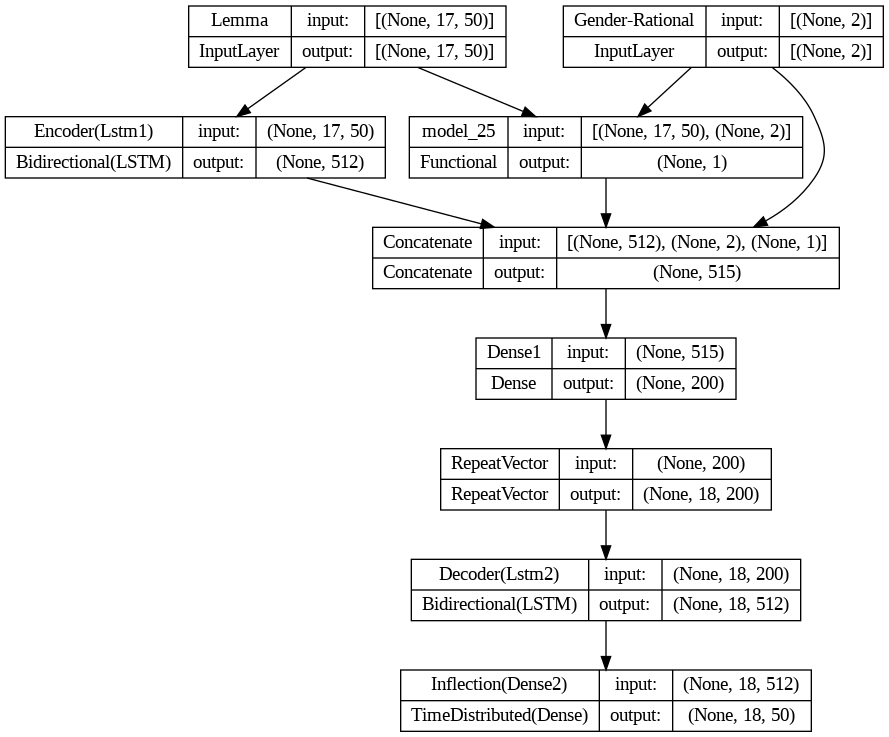

In [88]:
print(mix_model.summary())
plot_model(mix_model, to_file=mixModel3_path + '/architecture.png', show_shapes=True, show_layer_names=True)

### **Fit Model On Data**

#### **Old Dataset**

In [89]:
with tf.device('/GPU:0'):
  mix_model.fit([X_train_lemma_OH, X_train_genRat], y_train_inflection_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_genRat], y_dev_inflection_OH))  # starts training

Epoch 1/100
39/39 [==============================] - 18s 119ms/step - loss: 0.0510 - accuracy: 0.5643 - val_loss: 0.0387 - val_accuracy: 0.6222
Epoch 2/100
39/39 [==============================] - 1s 23ms/step - loss: 0.0379 - accuracy: 0.6210 - val_loss: 0.0366 - val_accuracy: 0.6240
Epoch 3/100
39/39 [==============================] - 1s 20ms/step - loss: 0.0358 - accuracy: 0.6459 - val_loss: 0.0349 - val_accuracy: 0.6659
Epoch 4/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0343 - accuracy: 0.6679 - val_loss: 0.0334 - val_accuracy: 0.6773
Epoch 5/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0331 - accuracy: 0.6887 - val_loss: 0.0324 - val_accuracy: 0.6975
Epoch 6/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0317 - accuracy: 0.7057 - val_loss: 0.0310 - val_accuracy: 0.7224
Epoch 7/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0304 - accuracy: 0.7181 - val_loss: 0.0302 - val_accuracy: 0.7209
Epoc

In [90]:
mix_model = load_model(checkpoint_filepath)
mix_model.evaluate([X_test_lemma_OH, X_test_genRat], [y_test_inflection_OH])

33/33 [==============================] - 2s 8ms/step - loss: 0.0036 - accuracy: 0.9868


[0.0035754896234720945, 0.986759603023529]

#### **New Dataset**

In [91]:
with tf.device('/GPU:0'):
  mix_model.fit([X_train_lemma_new_OH, X_train_genRat_new], y_train_inflection_new_OH, batch_size=batch_size, epochs=100, callbacks=[checkpoint], validation_data=([X_dev_lemma_new_OH, X_dev_genRat_new], y_dev_inflection_new_OH))  # starts training

Epoch 1/100
16/16 [==============================] - 11s 156ms/step - loss: 0.0403 - accuracy: 0.6661 - val_loss: 0.0264 - val_accuracy: 0.7174
Epoch 2/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0244 - accuracy: 0.7415 - val_loss: 0.0206 - val_accuracy: 0.7805
Epoch 3/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0183 - accuracy: 0.8111 - val_loss: 0.0171 - val_accuracy: 0.8252
Epoch 4/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0144 - accuracy: 0.8538 - val_loss: 0.0157 - val_accuracy: 0.8393
Epoch 5/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0119 - accuracy: 0.8809 - val_loss: 0.0143 - val_accuracy: 0.8541
Epoch 6/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0095 - accuracy: 0.9088 - val_loss: 0.0134 - val_accuracy: 0.8690
Epoch 7/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0080 - accuracy: 0.9271 - val_loss: 0.0138 - val_accuracy: 0.8699
Epoc

In [92]:
# evaluate new dataset
mix_model = load_model(checkpoint_filepath)
mix_model.evaluate([X_test_lemma_new_OH, X_test_genRat_new], [y_test_inflection_new_OH])

19/19 [==============================] - 2s 11ms/step - loss: 0.0025 - accuracy: 0.9894


[0.0024780763778835535, 0.9894444346427917]

### **Train analyze**

#### **Old Data**

In [93]:
train_pred = mix_model.predict([X_train_lemma_OH, X_train_genRat])
train_pred_OH = oneHot3D(train_pred)
train_error_num, train_acc_num = checkAccuracy(train_pred_OH, y_train_inflection_OH)
train_error_num, train_acc_num

78/78 [==============================] - 3s 8ms/step


(6, 0.9975757575757576)

In [94]:
train_errorAnalysis = reportErrorAnalysis(trainData[0], trainData[5], train_pred_OH, y_train_inflection_OH, mixModel3_path + "/train_errorAnalysis.csv")
train_errorAnalysis

,index,lemma,b/s,inflection,predict
0,599,diymuqrATiy~,1,diymuwqrATiy~iyn,diymuqqAATiy~iyn
1,863,tilofizyuwn,1,tilofizyuwnAt,tilofiyyuwnAt
2,1824,yaxot,0,yuxuwt,yuyuwt
3,1977,diymuqrATiy~ap,1,diymuwqrATiy~At,diymuwqAATiy~At
4,2083,klAsiykiy~,1,klAsiykiy~iyn,kllsiykiy~iyn
5,2206,finizuwil~iy~,1,finizowiyl~iy~iyn,finizowill~iy~iyn


In [95]:
checkAccuracy_anyAcceptableInflectionInDataset(trainData[0], train_pred_OH, dic_lemmaInflection)

(6, 0.9975757575757576)

In [96]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(train_errorAnalysis))

(Broken error %, Sound error %):  (16.666666666666664, 83.33333333333334)


#### **New Data**

In [97]:
new_train_pred = mix_model.predict([X_train_lemma_new_OH, X_train_genRat_new])
new_train_pred_OH = oneHot3D(new_train_pred)
new_train_error_num, new_train_acc_num = checkAccuracy(new_train_pred_OH, y_train_inflection_new_OH)
new_train_error_num, new_train_acc_num

32/32 [==============================] - 2s 7ms/step


(101, 0.899)

In [98]:
new_train_errorAnalysis = reportErrorAnalysis(trainData_new[0], None, new_train_pred_OH, y_train_inflection_new_OH, mixModel3_path + "/train_errorAnalysis_new.csv")
new_train_errorAnalysis

,index,lemma,b/s,inflection,predict
0,4,{iti~hAm,NAN,Aiti~hAmAt,Ait~ihAmAt
1,27,muqada~s,NAN,muqada~sAt,muqad~asAt
2,28,tawatu~r,NAN,tawatu~rAt,tawat~urAt
3,30,tilofizyuwn,NAN,tilofizyuwnAt,tilofiyyuwnAt
4,37,munaZa~map,NAN,munaZa~mAt,munaZ~amAt
...,...,...,...,...,...
96,966,murawi~j,NAN,murawi~jiyn,muraw~ijiyn
97,975,muta>ahi~l,NAN,muta>ahi~liyn,muta>ah~iliyn
98,976,takatu~l,NAN,takatu~lAt,takat~ulAt
99,990,mukabi~r,NAN,mukabi~rAt,mukab~irAt


In [99]:
checkAccuracy_anyAcceptableInflectionInDataset(trainData_new[0], new_train_pred_OH, dic_lemmaInflection)

(88, 0.912)

In [100]:
# # Report Percentage of Unseen Errors in Test set
# errorIndices_test = new_train_errorAnalysis['index'].tolist()
# unseenIndices_test = unseenLemInfIndices_train_new_df['index'].tolist()

# print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
# print(reportPercentageOfUnseenErrors(errorIndices_test, unseenIndices_test))

### **Dev analyze**

#### **Old Data**

In [101]:
dev_pred = mix_model.predict([X_dev_lemma_OH, X_dev_genRat])
dev_pred_OH = oneHot3D(dev_pred)
dev_error_num, dev_acc_num = checkAccuracy(dev_pred_OH, y_dev_inflection_OH)
dev_error_num, dev_acc_num

34/34 [==============================] - 0s 6ms/step


(90, 0.9150943396226415)

In [102]:
dev_errorAnalysis = reportErrorAnalysis(devData[0], devData[5] , dev_pred_OH, y_dev_inflection_OH, mixModel3_path + "/dev_errorAnalysis_with_bs.csv")
dev_errorAnalysis

,index,lemma,b/s,inflection,predict
0,59,nAdiy,0,>anodiyap,nawAdiy
1,193,>amoriykiy~,1,>amoriykiy~iyn,>amiyrokiy~iyn
2,213,na$AT,0,>ano$iTap,na$ATAt
3,229,mujawohar,1,mujawoharAt,mujahawahAt
4,235,masoEaY,0,masAE,masAEiy
...,...,...,...,...,...
85,1011,faHoS,1,fuHuwSAt,fuHuwS
86,1016,mujal~ad,1,mujal~adAt,mujad~adAt
87,1025,mutarojim,1,mutarojimiyn,murotajimiyn
88,1043,musotaEoTiy,1,musotaEoTiyn,musotaToEiyn


In [103]:
'''bstuple = [dev_errorAnalysis['b/s'], dev_errorAnalysis['b/s predict']]
c = 0
n = len(bstuple[0])
for i in range(n):
  if not bstuple[0][i] == bstuple[1][i]: c+=1

c/n'''

"bstuple = [dev_errorAnalysis['b/s'], dev_errorAnalysis['b/s predict']]\nc = 0\nn = len(bstuple[0])\nfor i in range(n):\n  if not bstuple[0][i] == bstuple[1][i]: c+=1\n\nc/n"

In [104]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(dev_errorAnalysis))

(Broken error %, Sound error %):  (53.333333333333336, 46.666666666666664)


In [105]:
checkAccuracy_anyAcceptableInflectionInDataset(devData[0], dev_pred_OH, dic_lemmaInflection)

(62, 0.9415094339622642)

In [106]:
# Report Percentage of Unseen Errors in Dev set
errorIndices_dev = dev_errorAnalysis['index'].tolist()
unseenIndices_dev = unseenLemInfIndices_dev_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_dev, unseenIndices_dev))

Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples
(97.77777777777777, 75.86206896551724)


#### **New Data**

In [107]:
new_dev_pred = mix_model.predict([X_dev_lemma_new_OH, X_dev_genRat_new])
new_dev_pred_OH = oneHot3D(new_dev_pred)
new_dev_error_num, new_dev_acc_num = checkAccuracy(new_dev_pred_OH, y_dev_inflection_new_OH)
new_dev_error_num, new_dev_acc_num

11/11 [==============================] - 0s 6ms/step


(36, 0.8950437317784257)

In [108]:
new_dev_errorAnalysis = reportErrorAnalysis(devData_new[0], None, new_dev_pred_OH, y_dev_inflection_new_OH, mixModel3_path + "/dev_errorAnalysis_new.csv")
new_dev_errorAnalysis

,index,lemma,b/s,inflection,predict
0,25,muHali~l,NAN,muHali~liyn,muHal~iliyn
1,26,muwali~d,NAN,muwali~dAt,muwal~idAt
2,39,>uwrubi~y~,NAN,>uwruwbi~y~At,>uwruwbiyy~At
3,66,muxaTa~T,NAN,muxaTa~TAt,muxaT~aTAt
4,67,klAsiykiy~,NAN,klAsiykiy~iyn,kllsiykiy~At
5,68,muHaSi~l,NAN,muHaSi~lAt,muHaS~ilAt
6,77,ta>amu~l,NAN,ta>amu~lAt,ta>am~ulAt
7,86,musama~Y,NAN,musama~yAt,musam~ayAt
8,101,mu$Arik,NAN,mu$Arikiyn,mu$ArikAt
9,108,muda~Eiy,NAN,muda~Eiyn,mud~aEiyn


In [109]:
checkAccuracy_anyAcceptableInflectionInDataset(devData_new[0], new_dev_pred_OH, dic_lemmaInflection)

(33, 0.9037900874635568)

In [110]:
# Report Percentage of Unseen Errors in Test set
errorIndices_test = new_dev_errorAnalysis['index'].tolist()
unseenIndices_test = unseenLemInfIndices_dev_new_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_test, unseenIndices_test))

Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples
(100.0, 10.495626822157435)


### **Test analyze**

#### **Old Data**

In [111]:
test_pred = mix_model.predict([X_test_lemma_OH, X_test_genRat])
test_pred_OH = oneHot3D(test_pred)
test_error_num, test_acc_num = checkAccuracy(test_pred_OH, y_test_inflection_OH)
test_error_num, test_acc_num

33/33 [==============================] - 0s 7ms/step


(76, 0.9260700389105059)

In [112]:
test_errorAnalysis = reportErrorAnalysis(testData[0], testData[5], test_pred_OH, y_test_inflection_OH, mixModel3_path + "/test_errorAnalysis_with_bs.csv")
test_errorAnalysis

,index,lemma,b/s,inflection,predict
0,66,mu$okilap,0,ma$Akil,mu$okilAt
1,94,na$AT,0,>ano$iTap,na$ATAt
2,178,minaS~ap,1,minaS~At,munaS~At
3,234,taqoniy~,1,taqoniy~iyn,taqoniyiyn
4,330,rafiyqap,1,rafiyqAt,rafA}iq
...,...,...,...,...,...
71,989,maval,0,>amovAl,mamolAl
72,997,may~it,0,mawotaY,>amowAt
73,1014,manobat,0,manAbit,manAtib
74,1018,maqAm,1,maqAmAt,maqA}im


In [113]:
'''bstuple = [test_errorAnalysis['b/s'], test_errorAnalysis['b/s predict']]
c = 0
n = len(bstuple[0])
for i in range(n):
  if not bstuple[0][i] == bstuple[1][i]: c+=1

c/n'''

"bstuple = [test_errorAnalysis['b/s'], test_errorAnalysis['b/s predict']]\nc = 0\nn = len(bstuple[0])\nfor i in range(n):\n  if not bstuple[0][i] == bstuple[1][i]: c+=1\n\nc/n"

In [114]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(test_errorAnalysis))

(Broken error %, Sound error %):  (51.31578947368421, 48.68421052631579)


In [115]:
checkAccuracy_anyAcceptableInflectionInDataset(testData[0], test_pred_OH, dic_lemmaInflection)

(56, 0.9455252918287937)

In [116]:
# Report Percentage of Unseen Errors in Test set
errorIndices_test = test_errorAnalysis['index'].tolist()
unseenIndices_test = unseenLemInfIndices_test_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_test, unseenIndices_test))

Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples
(96.05263157894737, 70.1923076923077)


#### **New Data**

In [117]:
new_test_pred = mix_model.predict([X_test_lemma_new_OH, X_test_genRat_new])
new_test_pred_OH = oneHot3D(new_test_pred)
new_test_error_num, new_test_acc_num = checkAccuracy(new_test_pred_OH, y_test_inflection_new_OH)
new_test_error_num, new_test_acc_num

19/19 [==============================] - 0s 6ms/step


(47, 0.9216666666666666)

In [118]:
new_test_errorAnalysis = reportErrorAnalysis(testData_new[0], None, new_test_pred_OH, y_test_inflection_new_OH, mixModel3_path + "/new_test_errorAnalysis.csv")
new_test_errorAnalysis

,index,lemma,b/s,inflection,predict
0,16,Huja~p,NAN,Hujaj,Huj~jAt
1,21,mufaki~r,NAN,mufaki~riyn,mufak~iriyn
2,24,musala~m,NAN,musala~mAt,musal~amAt
3,28,muwaZa~f,NAN,muwaZa~fiyn,muwaZ~afiyn
4,129,muqawi~m,NAN,muqawi~mAt,muqaw~imAt
5,147,qayi~m,NAN,qayi~miyn,qalAmAm
6,152,kuli~ya~p,NAN,kuli~y~At,kul~i~~At
7,158,muqadi~m,NAN,muqadi~miyn,muqad~imiyn
8,162,tadafu~q,NAN,tadafu~qAt,tadaf~uqAt
9,169,taHafu~Z,NAN,taHafu~ZAt,taHaf~uZAt


In [119]:
# Report Percentage of Unseen Errors in Test set
errorIndices_test = new_test_errorAnalysis['index'].tolist()
unseenIndices_test = unseenLemInfIndices_test_new_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_test, unseenIndices_test))

Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples
(100.0, 7.833333333333334)


In [120]:
checkAccuracy_anyAcceptableInflectionInDataset(testData_new[0], new_test_pred_OH, dic_lemmaInflection)

(40, 0.9333333333333333)